## Importing the libraries

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

## Importing the dataset

In [ ]:
wind_data = xr.open_dataset("wind_2023.nc")

## Data Preprocessing

In [ ]:
# Convert to DataFrame
wind_data_df = wind_data.to_dataframe()

# Select only numeric columns
numeric_columns = wind_data_df.select_dtypes(include=np.number).columns

# Calculate the mean of numeric columns
mean_values = wind_data_df[numeric_columns].mean()

# Replace missing values in numeric columns with the mean
wind_data_df[numeric_columns] = wind_data_df[numeric_columns].fillna(mean_values)

# Convert DataFrame back to Dataset
wind_data_cleaned = xr.Dataset.from_dataframe(wind_data_df)

# Convert the cleaned Dataset back to DataFrame to check for missing values
wind_data_cleaned_df = wind_data_cleaned.to_dataframe()

# Check for missing values
missing_values = wind_data_cleaned_df.isnull().sum()

# Display missing values count for each column
print("Missing values count for each column:")
print(missing_values)

# Optional: Check if there are any missing values at all
if missing_values.any():
    print("There are still missing values in the dataset.")
else:
    print("No missing values remain in the dataset.")

# Convert DataFrame back to Dataset
wind_data_cleaned = xr.Dataset.from_dataframe(wind_data_df)

wind_data = wind_data_cleaned

Missing values count for each column:
measured_wind_direction_quality    0
measured_wind_speed_quality        0
measured_wind_direction            0
measured_wind_speed                0
station_longitude                  0
station_latitude                   0
station_height                     0
station_name                       0
state                              0
longitude                          0
latitude                           0
era5_wind_speed                    0
era5_wind_direction                0
icon_d2_run                        0
icon_d2_step                       0
icon_d2_wind_speed                 0
icon_d2_wind_direction             0
icon_eu_run                        0
icon_eu_step                       0
icon_eu_wind_speed                 0
icon_eu_wind_direction             0
dtype: int64
No missing values remain in the dataset.


## Examine Dimensions, Coordinates and Data Variables

In [ ]:
wind_data.dims

Frozen({'station_id': 10, 'time': 8760})

In [ ]:
wind_data.coords

Coordinates:
  * station_id  (station_id) int64 303 433 701 1200 ... 3821 4625 5426 15207
  * time        (time) datetime64[ns] 2023-01-01 ... 2023-12-31T23:00:00

In [ ]:
wind_data.data_vars

Data variables:
    measured_wind_direction_quality  (station_id, time) float64 10.0 ... 1.0
    measured_wind_speed_quality      (station_id, time) float64 10.0 ... 1.0
    measured_wind_direction          (station_id, time) float64 230.0 ... 200.0
    measured_wind_speed              (station_id, time) float64 8.9 8.5 ... 4.8
    station_longitude                (station_id, time) float32 13.5 ... 9.359
    station_latitude                 (station_id, time) float32 52.06 ... 51.28
    station_height                   (station_id, time) float64 55.0 ... 317.0
    station_name                     (station_id, time) object 'Baruth' ... '...
    state                            (station_id, time) object 'Brandenburg' ...
    longitude                        (station_id, time) float32 13.5 ... 9.359
    latitude                         (station_id, time) float32 52.06 ... 51.28
    era5_wind_speed                  (station_id, time) float32 7.45 ... 5.91
    era5_wind_direction          

## Plot Measured Wind Speed and Direction for Different Stations

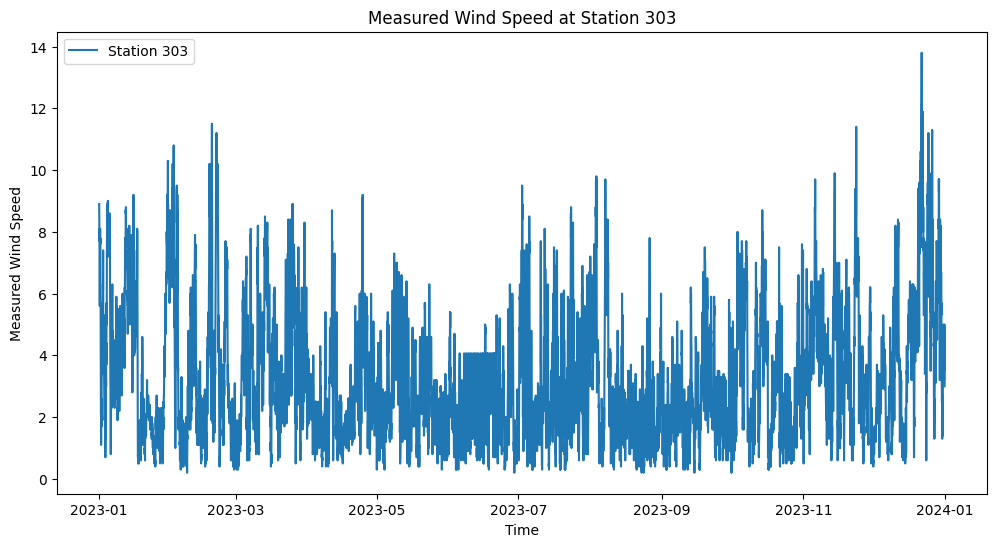

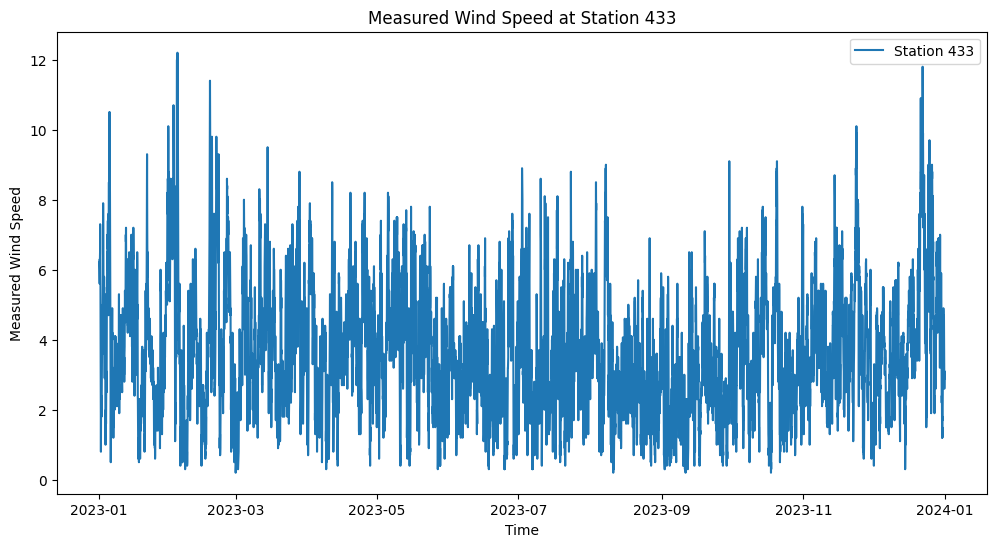

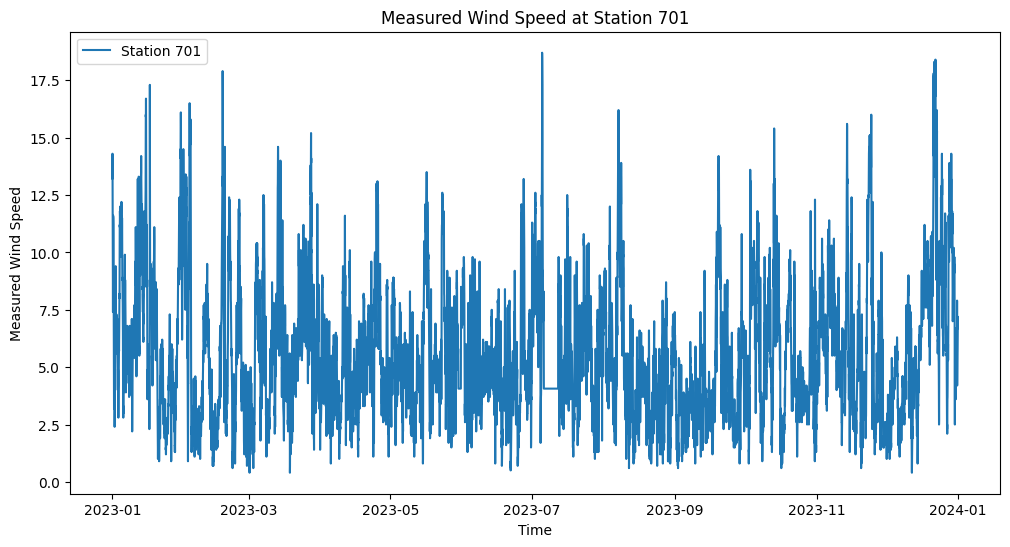

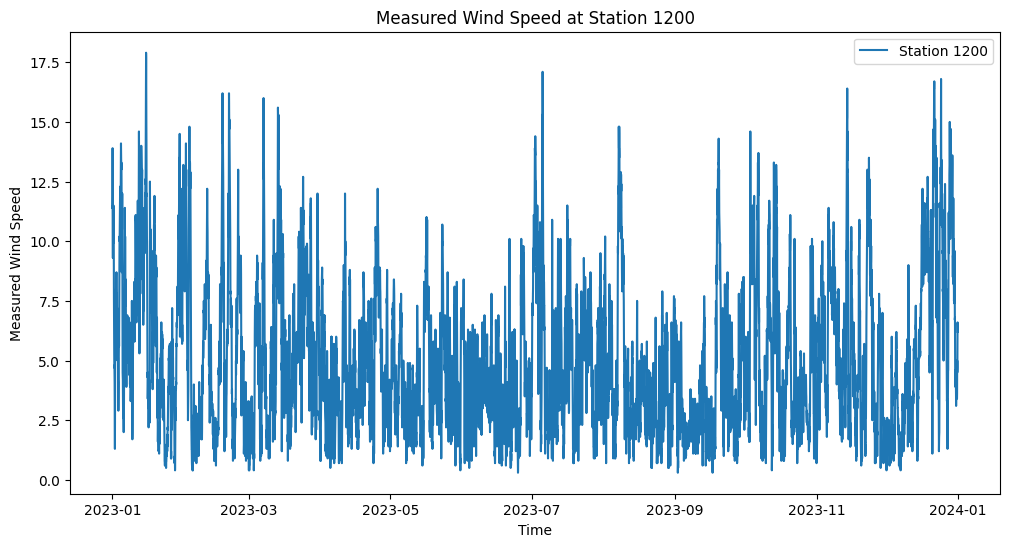

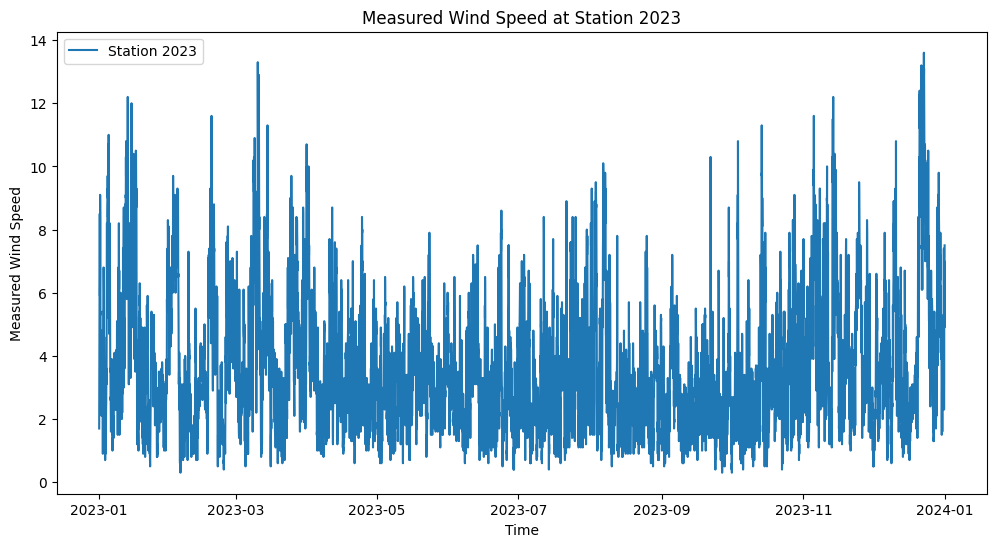

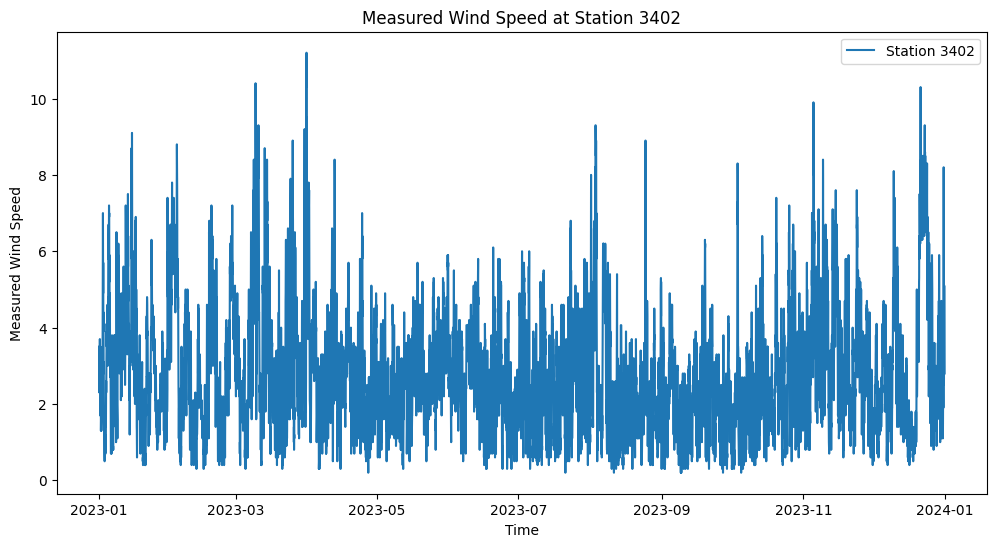

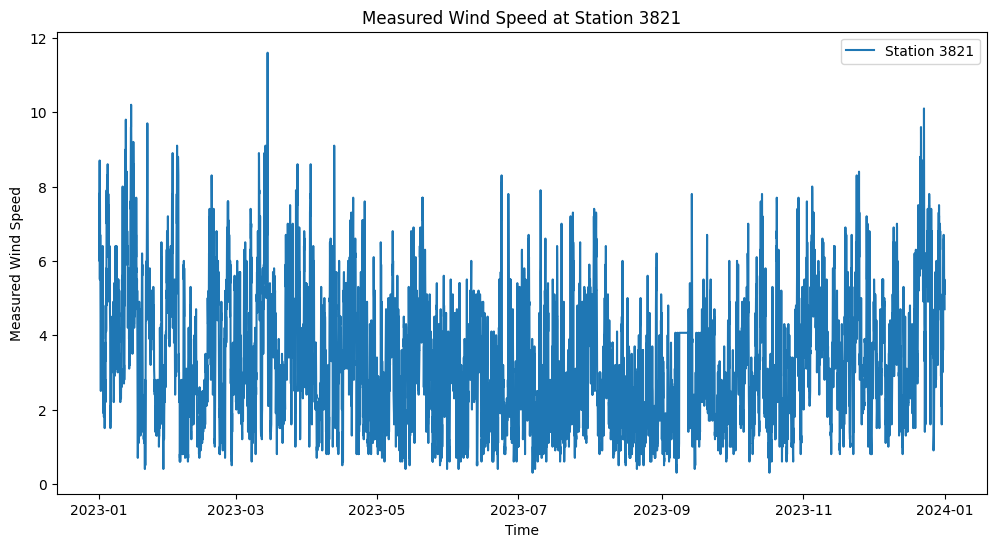

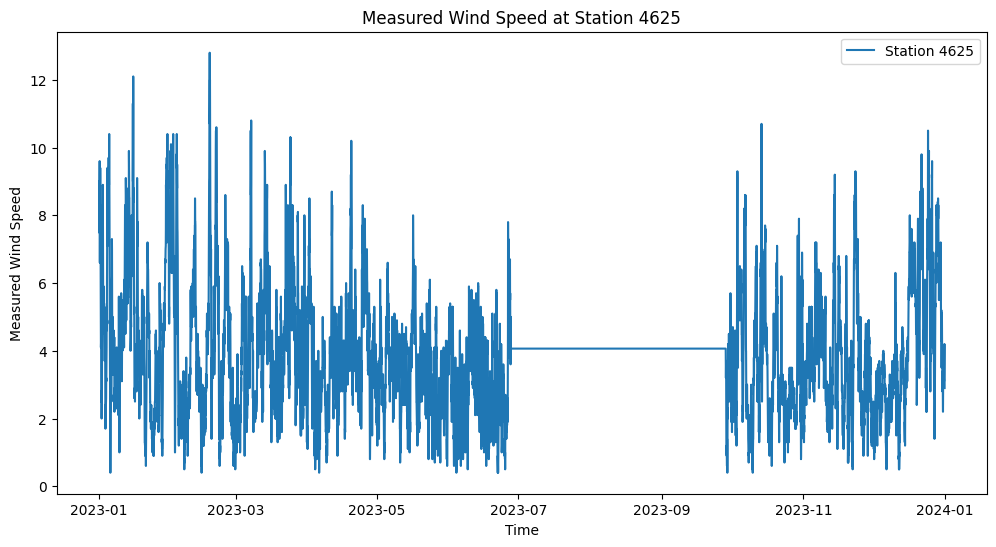

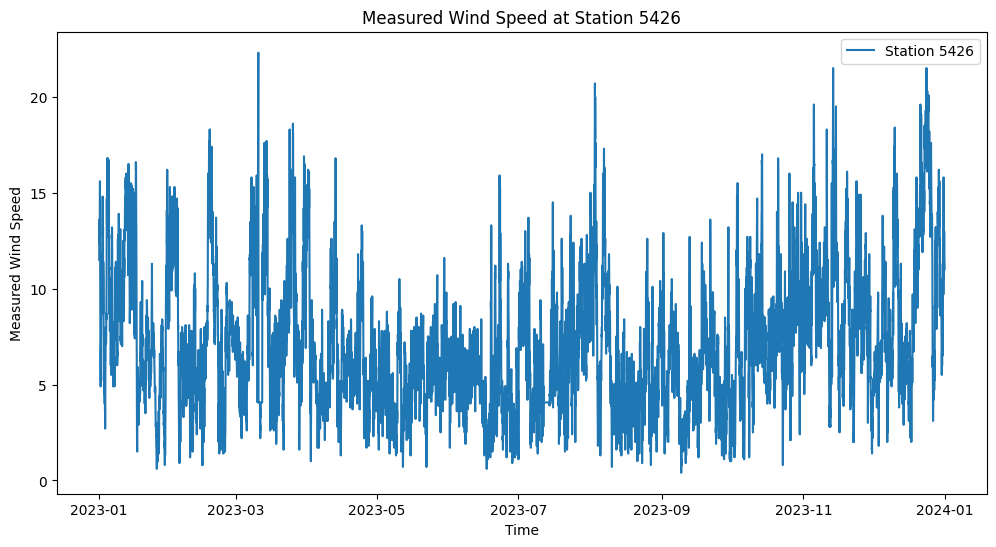

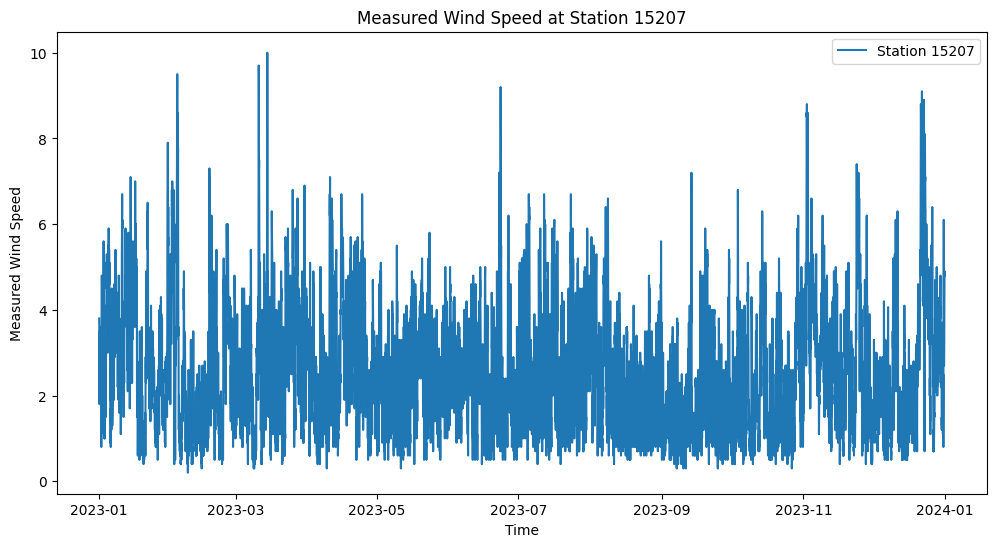

In [ ]:

# Iterate over each station
station_ids = wind_data.station_id.values

for station_id in station_ids:
    plt.figure(figsize=(12, 6))

    # Plot measured wind speed for the current station
    plt.plot(wind_data.time, wind_data.measured_wind_speed.sel(station_id=station_id), label=f'Station {station_id}')

    plt.xlabel('Time')
    plt.ylabel('Measured Wind Speed')
    plt.legend()
    plt.title(f'Measured Wind Speed at Station {station_id}')
    plt.show()


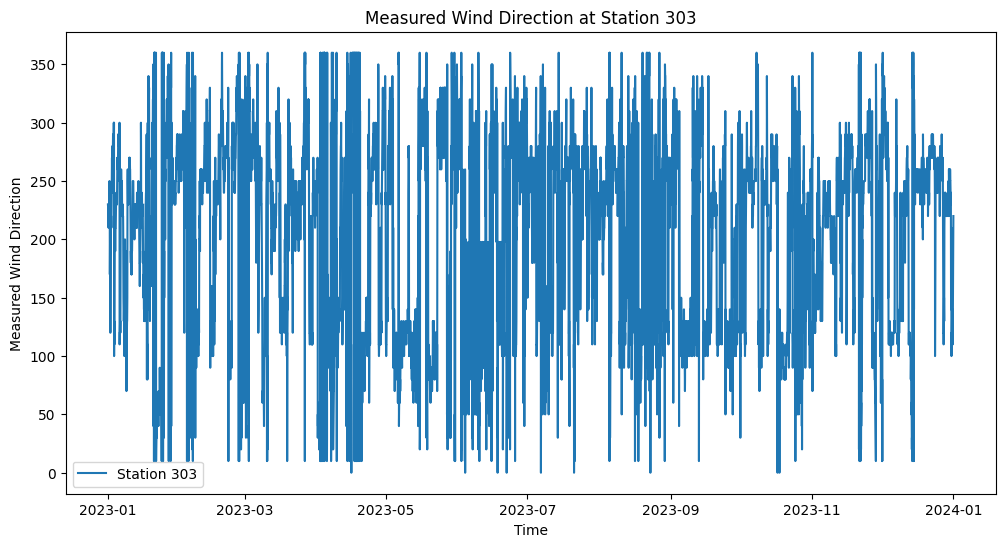

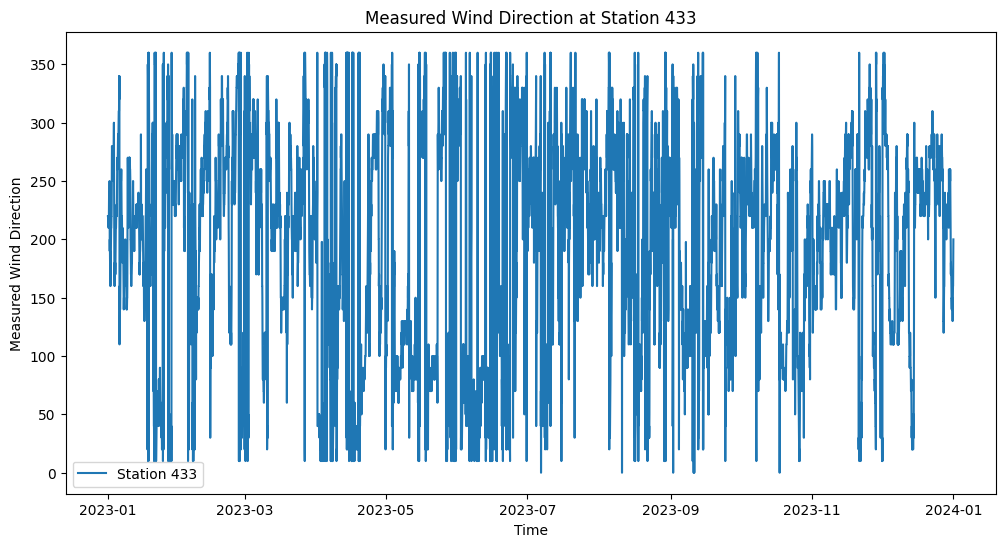

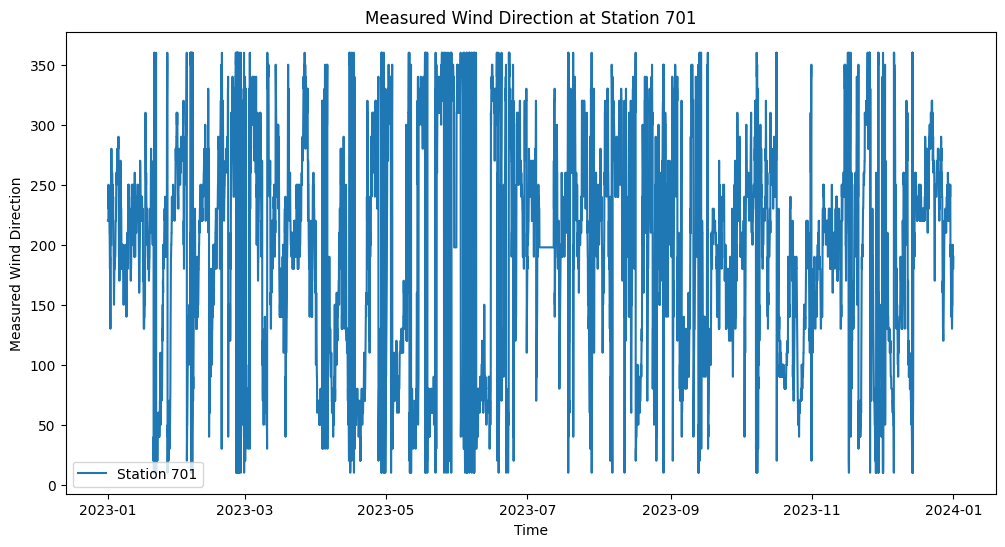

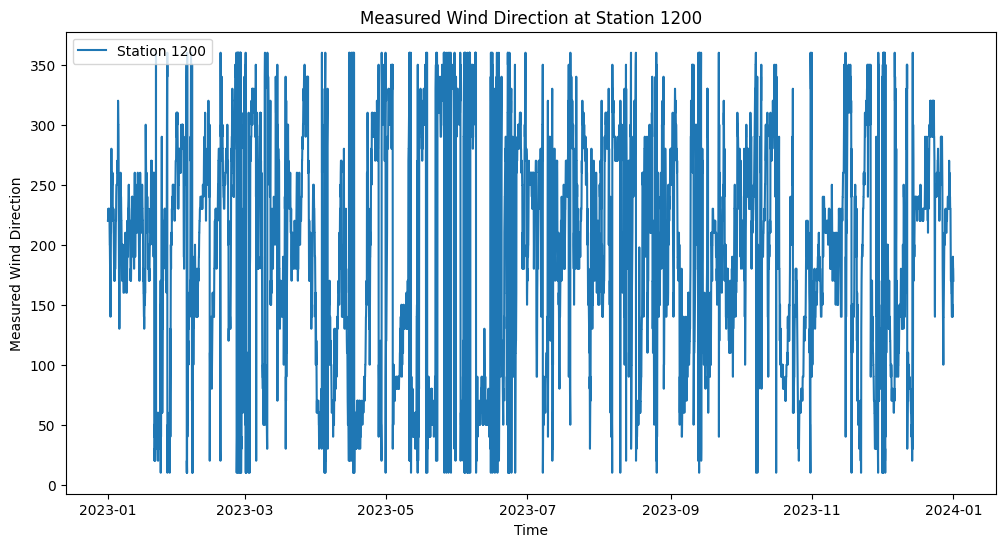

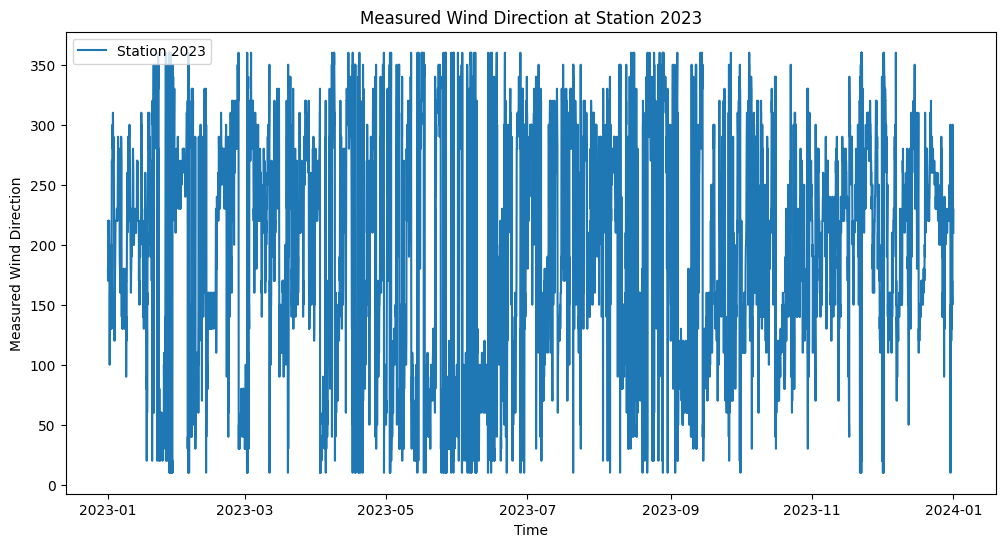

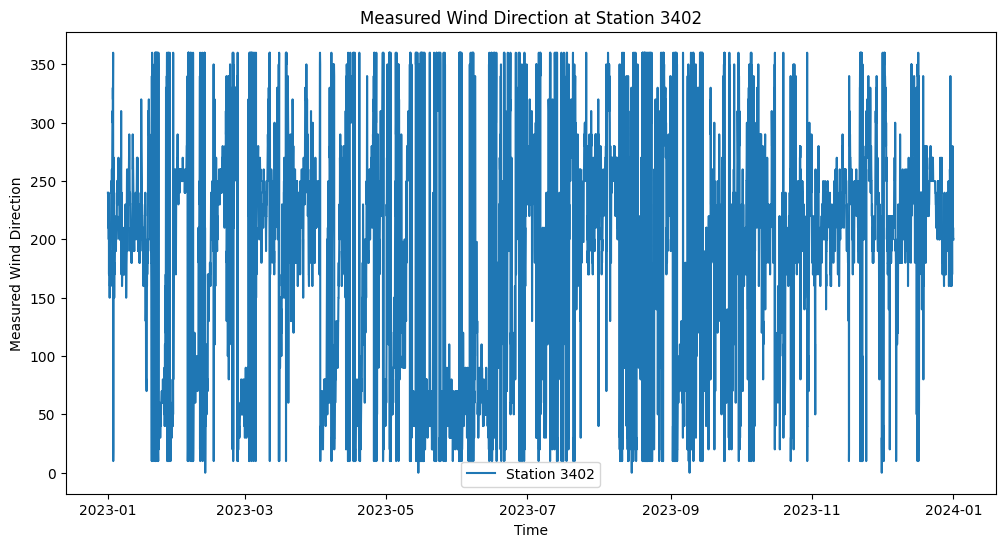

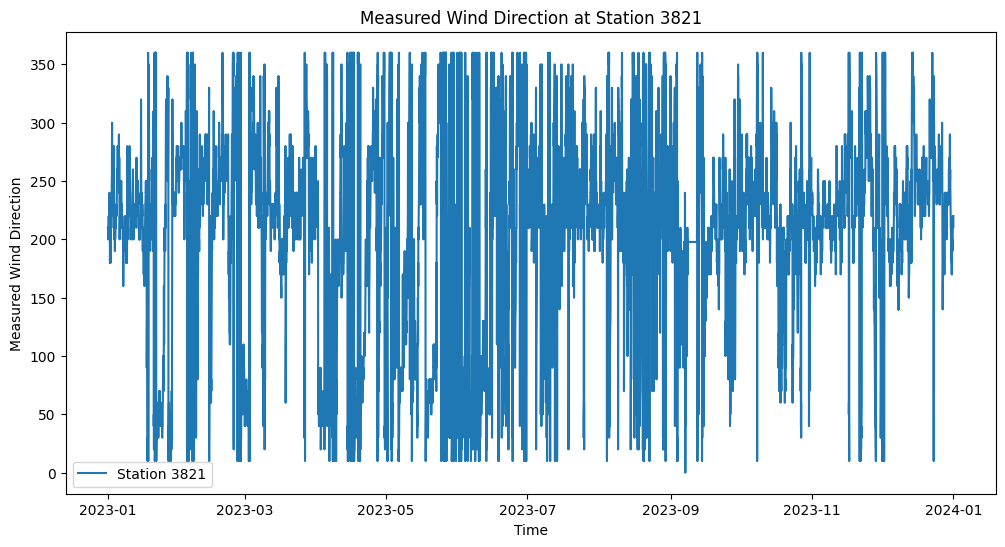

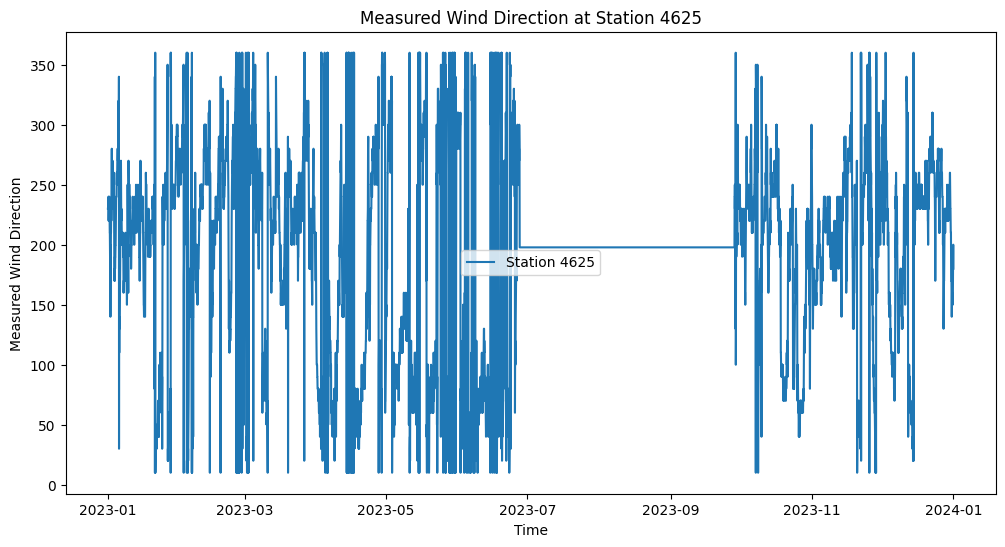

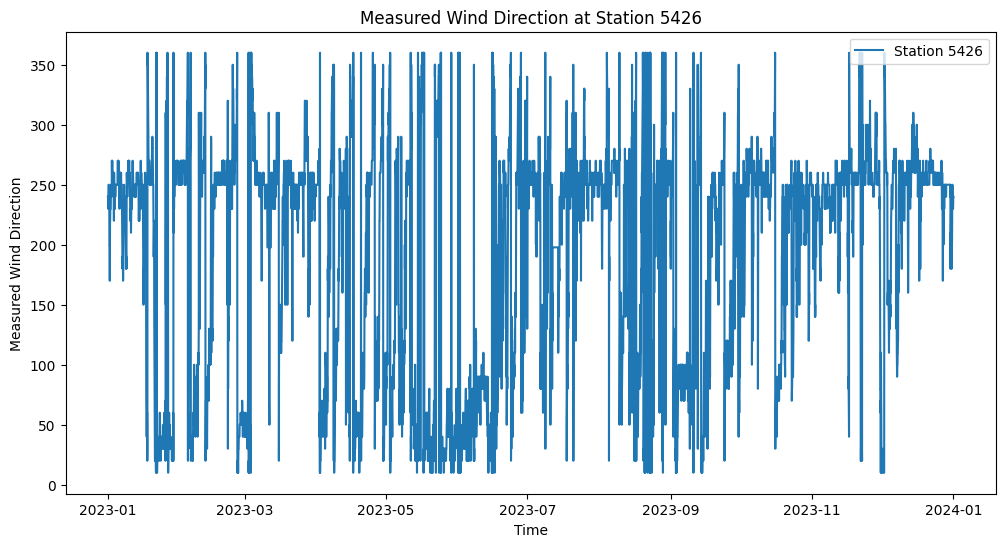

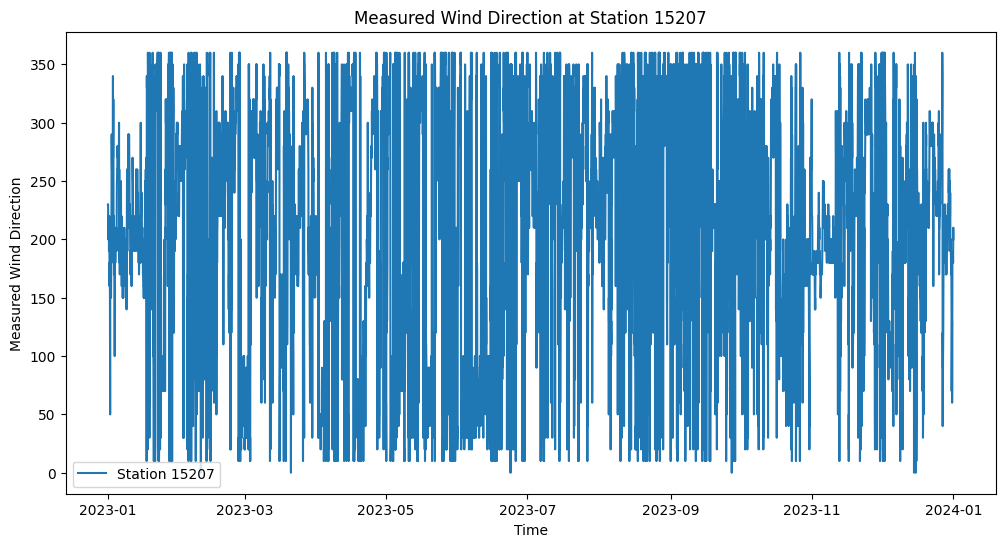

In [ ]:
# Iterate over each station
station_ids = wind_data.station_id.values

for station_id in station_ids:
    plt.figure(figsize=(12, 6))

    # Plot measured wind direction for the current station
    plt.plot(wind_data.time, wind_data.measured_wind_direction.sel(station_id=station_id), label=f'Station {station_id}')

    plt.xlabel('Time')
    plt.ylabel('Measured Wind Direction')
    plt.legend()
    plt.title(f'Measured Wind Direction at Station {station_id}')
    plt.show()

## Statistical Metrics to Evaluate Model Performance

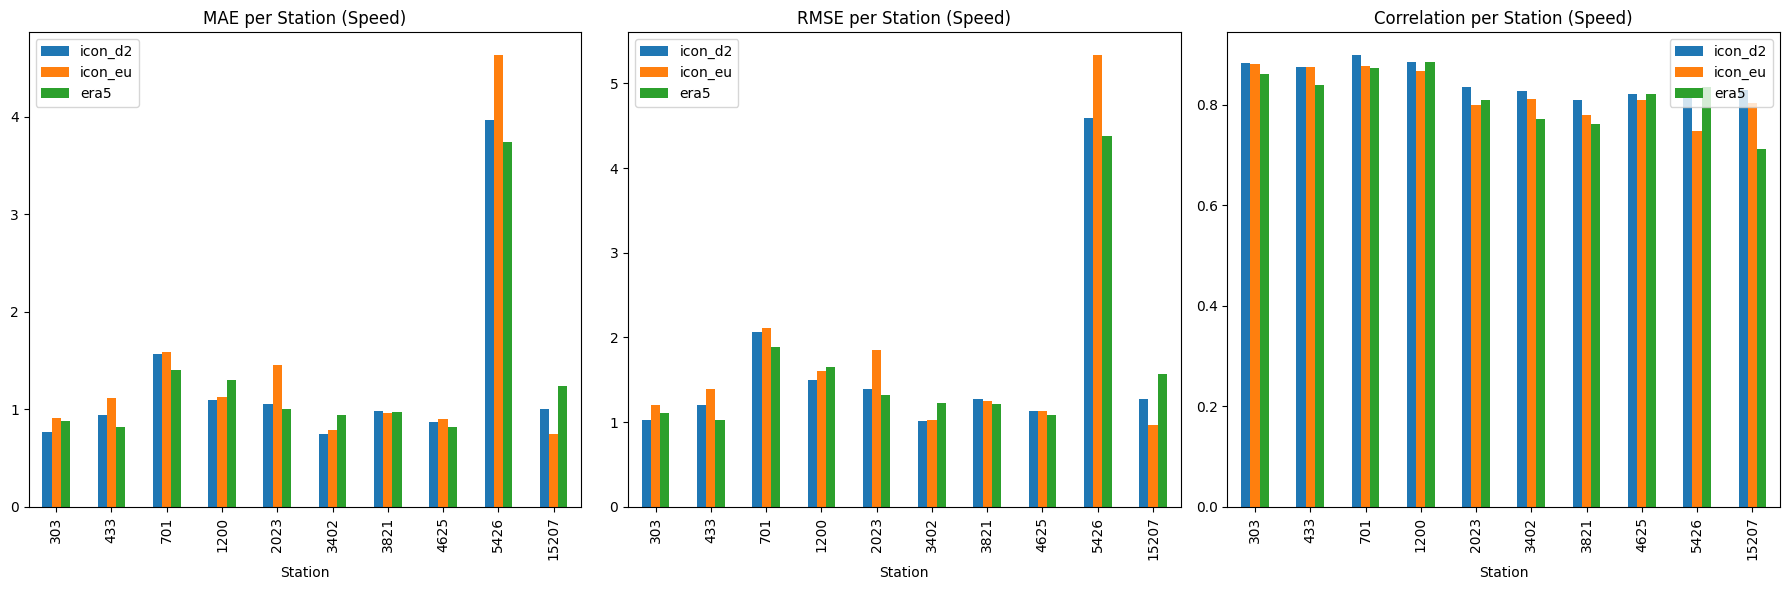

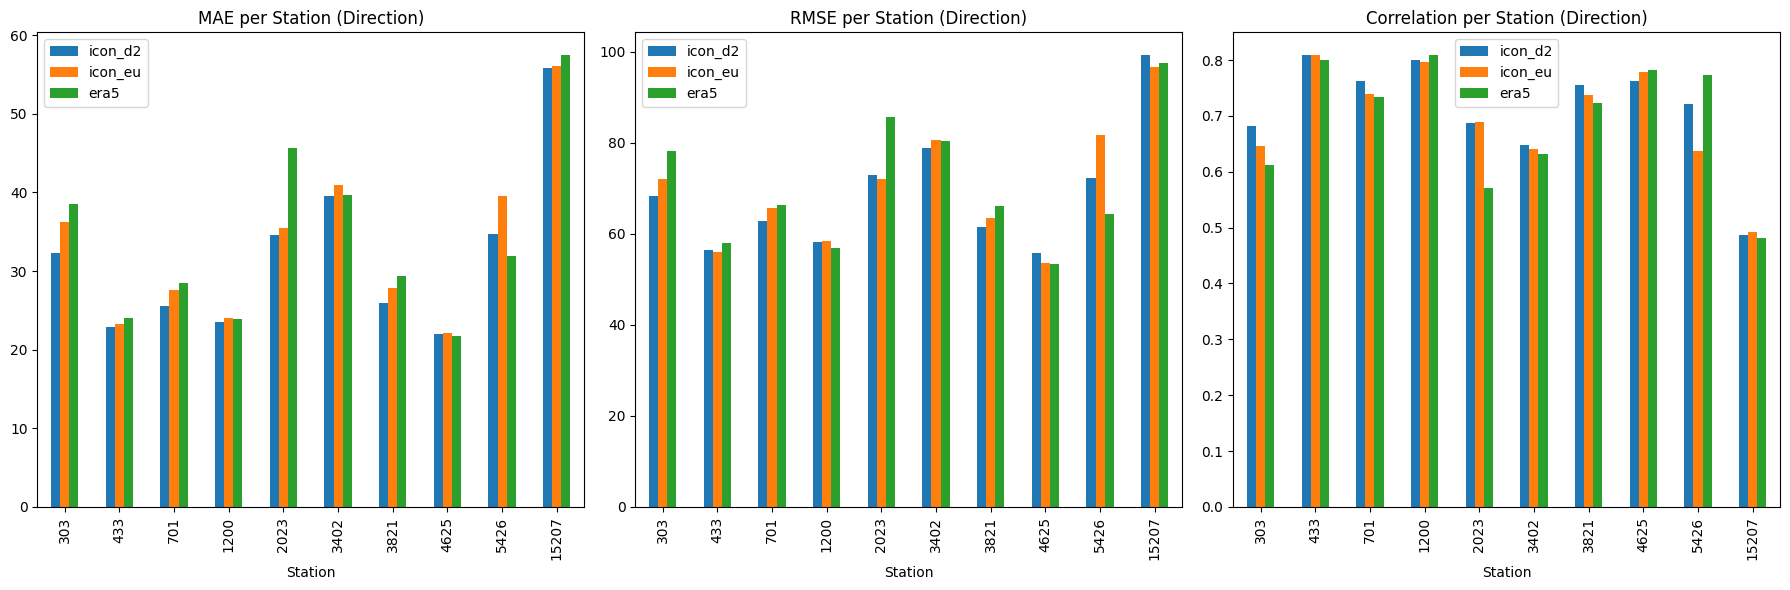


Summary of Wind Speed Model Performance Metrics:
      Model       MAE      RMSE  Correlation
0  icon_d2  1.300536  1.646513     0.848323
1  icon_eu  1.424597  1.786150     0.825293
2     era5  1.312491  1.644922     0.817556

Summary of Wind Direction Model Performance Metrics:
      Model        MAE       RMSE  Correlation
0  icon_d2  31.682161  68.593146     0.711637
1  icon_eu  33.315183  69.970025     0.696870
2     era5  34.071208  70.639476     0.692057


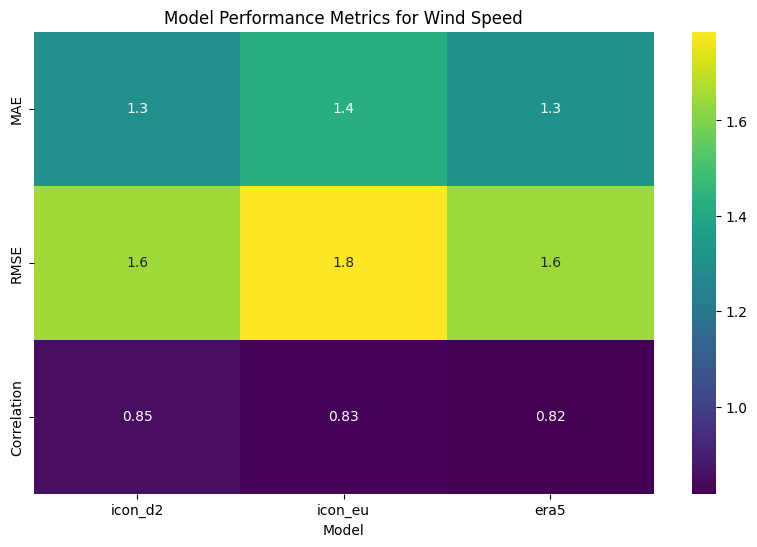

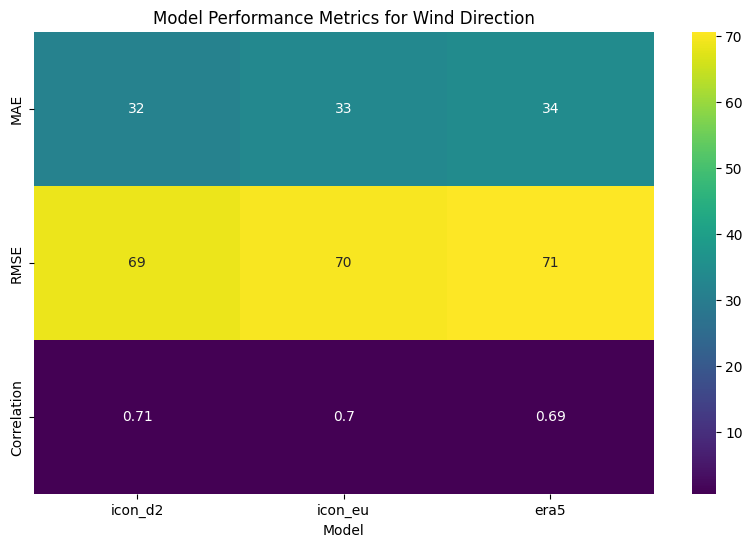

In [ ]:

# Function to evaluate models
def evaluate_model(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    return mae, rmse, correlation


# Initialize lists to store metrics for each station
mae_per_station_speed = []
rmse_per_station_speed = []
corr_per_station_speed = []

mae_per_station_direction = []
rmse_per_station_direction = []
corr_per_station_direction = []

# Iterate over each station
station_ids = np.unique(wind_data['station_id'].values)

for station_id in station_ids:
    # Filter data for the current station
    station_data = wind_data.sel(station_id=station_id)

    # Wind Speed Evaluation
    y_true_speed = station_data['measured_wind_speed'].values
    y_pred_icon_d2_speed = station_data['icon_d2_wind_speed'].values
    y_pred_icon_eu_speed = station_data['icon_eu_wind_speed'].values
    y_pred_era5_speed = station_data['era5_wind_speed'].values

    mae_icon_d2_speed, rmse_icon_d2_speed, corr_icon_d2_speed = evaluate_model(y_true_speed, y_pred_icon_d2_speed)
    mae_icon_eu_speed, rmse_icon_eu_speed, corr_icon_eu_speed = evaluate_model(y_true_speed, y_pred_icon_eu_speed)
    mae_era5_speed, rmse_era5_speed, corr_era5_speed = evaluate_model(y_true_speed, y_pred_era5_speed)

    mae_per_station_speed.append({'Station': station_id, 'icon_d2': mae_icon_d2_speed, 'icon_eu': mae_icon_eu_speed, 'era5': mae_era5_speed})
    rmse_per_station_speed.append({'Station': station_id, 'icon_d2': rmse_icon_d2_speed, 'icon_eu': rmse_icon_eu_speed, 'era5': rmse_era5_speed})
    corr_per_station_speed.append({'Station': station_id, 'icon_d2': corr_icon_d2_speed, 'icon_eu': corr_icon_eu_speed, 'era5': corr_era5_speed})

    # Wind Direction Evaluation
    y_true_direction = station_data['measured_wind_direction'].values
    y_pred_icon_d2_direction = station_data['icon_d2_wind_direction'].values
    y_pred_icon_eu_direction = station_data['icon_eu_wind_direction'].values
    y_pred_era5_direction = station_data['era5_wind_direction'].values

    mae_icon_d2_direction, rmse_icon_d2_direction, corr_icon_d2_direction = evaluate_model(y_true_direction, y_pred_icon_d2_direction)
    mae_icon_eu_direction, rmse_icon_eu_direction, corr_icon_eu_direction = evaluate_model(y_true_direction, y_pred_icon_eu_direction)
    mae_era5_direction, rmse_era5_direction, corr_era5_direction = evaluate_model(y_true_direction, y_pred_era5_direction)

    mae_per_station_direction.append({'Station': station_id, 'icon_d2': mae_icon_d2_direction, 'icon_eu': mae_icon_eu_direction, 'era5': mae_era5_direction})
    rmse_per_station_direction.append({'Station': station_id, 'icon_d2': rmse_icon_d2_direction, 'icon_eu': rmse_icon_eu_direction, 'era5': rmse_era5_direction})
    corr_per_station_direction.append({'Station': station_id, 'icon_d2': corr_icon_d2_direction, 'icon_eu': corr_icon_eu_direction, 'era5': corr_era5_direction})

# Convert to DataFrames
mae_per_station_df_speed = pd.DataFrame(mae_per_station_speed).set_index('Station')
rmse_per_station_df_speed = pd.DataFrame(rmse_per_station_speed).set_index('Station')
corr_per_station_df_speed = pd.DataFrame(corr_per_station_speed).set_index('Station')

mae_per_station_df_direction = pd.DataFrame(mae_per_station_direction).set_index('Station')
rmse_per_station_df_direction = pd.DataFrame(rmse_per_station_direction).set_index('Station')
corr_per_station_df_direction = pd.DataFrame(corr_per_station_direction).set_index('Station')

# Plot MAE, RMSE, and Correlation for each station (Speed)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
mae_per_station_df_speed.plot(kind='bar', ax=plt.gca())
plt.title('MAE per Station (Speed)')

plt.subplot(1, 3, 2)
rmse_per_station_df_speed.plot(kind='bar', ax=plt.gca())
plt.title('RMSE per Station (Speed)')

plt.subplot(1, 3, 3)
corr_per_station_df_speed.plot(kind='bar', ax=plt.gca())
plt.title('Correlation per Station (Speed)')

plt.tight_layout()
plt.show()

# Plot MAE, RMSE, and Correlation for each station (Direction)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
mae_per_station_df_direction.plot(kind='bar', ax=plt.gca())
plt.title('MAE per Station (Direction)')

plt.subplot(1, 3, 2)
rmse_per_station_df_direction.plot(kind='bar', ax=plt.gca())
plt.title('RMSE per Station (Direction)')

plt.subplot(1, 3, 3)
corr_per_station_df_direction.plot(kind='bar', ax=plt.gca())
plt.title('Correlation per Station (Direction)')

plt.tight_layout()
plt.show()

# Summary of model performance metrics
metrics_speed = {
    'Model': ['icon_d2', 'icon_eu', 'era5'],
    'MAE': [
        np.mean([res['icon_d2'] for res in mae_per_station_speed]),
        np.mean([res['icon_eu'] for res in mae_per_station_speed]),
        np.mean([res['era5'] for res in mae_per_station_speed])
    ],
    'RMSE': [
        np.mean([res['icon_d2'] for res in rmse_per_station_speed]),
        np.mean([res['icon_eu'] for res in rmse_per_station_speed]),
        np.mean([res['era5'] for res in rmse_per_station_speed])
    ],
    'Correlation': [
        np.mean([res['icon_d2'] for res in corr_per_station_speed]),
        np.mean([res['icon_eu'] for res in corr_per_station_speed]),
        np.mean([res['era5'] for res in corr_per_station_speed])
    ]
}

metrics_direction = {
    'Model': ['icon_d2', 'icon_eu', 'era5'],
    'MAE': [
        np.mean([res['icon_d2'] for res in mae_per_station_direction]),
        np.mean([res['icon_eu'] for res in mae_per_station_direction]),
        np.mean([res['era5'] for res in mae_per_station_direction])
    ],
    'RMSE': [
        np.mean([res['icon_d2'] for res in rmse_per_station_direction]),
        np.mean([res['icon_eu'] for res in rmse_per_station_direction]),
        np.mean([res['era5'] for res in rmse_per_station_direction])
    ],
    'Correlation': [
        np.mean([res['icon_d2'] for res in corr_per_station_direction]),
        np.mean([res['icon_eu'] for res in corr_per_station_direction]),
        np.mean([res['era5'] for res in corr_per_station_direction])
    ]
}

metrics_df_speed = pd.DataFrame(metrics_speed)
metrics_df_direction = pd.DataFrame(metrics_direction)

print("\nSummary of Wind Speed Model Performance Metrics:\n", metrics_df_speed)
print("\nSummary of Wind Direction Model Performance Metrics:\n", metrics_df_direction)

# Plot heatmap for wind speed metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df_speed.set_index('Model').T, annot=True, cmap='viridis')
plt.title('Model Performance Metrics for Wind Speed')
plt.show()

# Plot heatmap for wind direction metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df_direction.set_index('Model').T, annot=True, cmap='viridis')
plt.title('Model Performance Metrics for Wind Direction')
plt.show()


## Time series forecasting model to predict future wind speeds and directions.

Processing Station ID: 303
Epoch 1/25
175/175 [==============================] - 6s 20ms/step - loss: 0.0130 - val_loss: 0.0058
Epoch 2/25
175/175 [==============================] - 2s 12ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 3/25
175/175 [==============================] - 2s 13ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/25
175/175 [==============================] - 2s 13ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 5/25
175/175 [==============================] - 2s 12ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 6/25
175/175 [==============================] - 3s 17ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 7/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 8/25
175/175 [==============================] - 2s 12ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 9/25
175/175 [==============================] - 2s 12ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 10/25
175/175 [==============================] - 2s 12ms/s

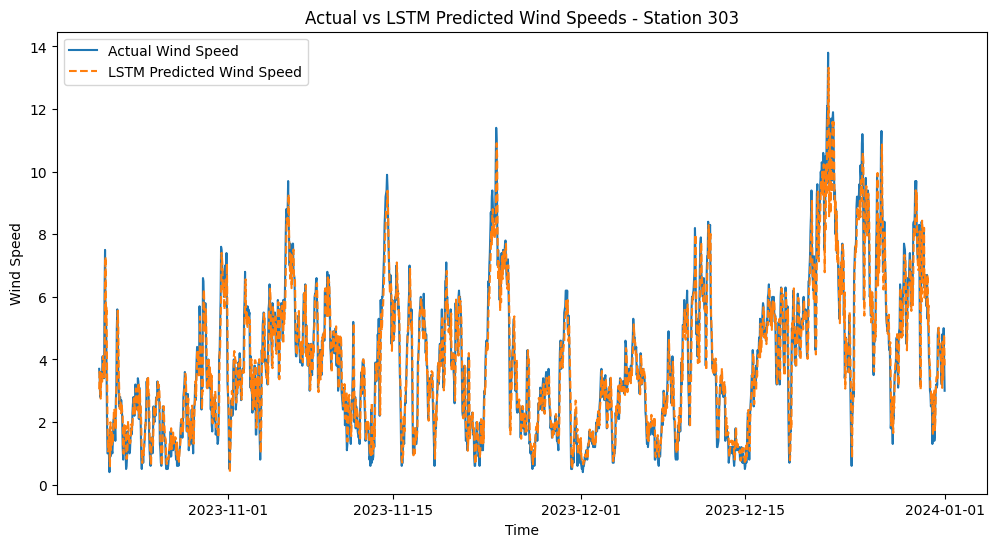

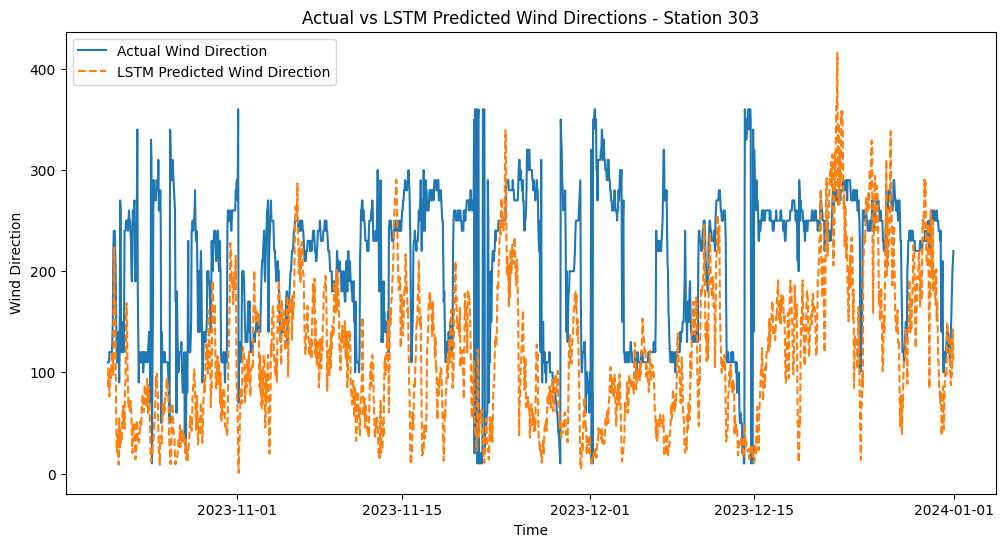

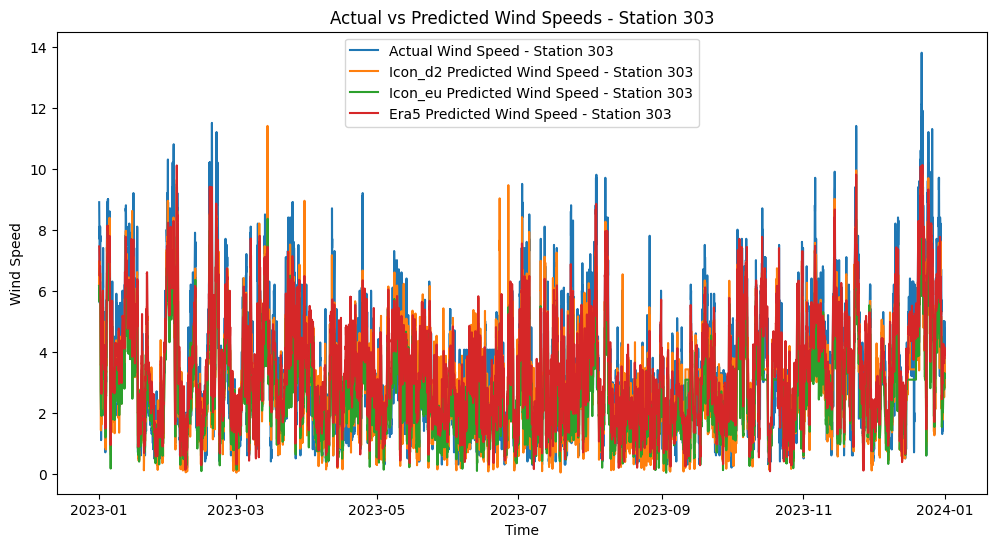

Processing Station ID: 433
Epoch 1/25
175/175 [==============================] - 4s 16ms/step - loss: 0.0121 - val_loss: 0.0053
Epoch 2/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 3/25
175/175 [==============================] - 3s 16ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/25
175/175 [==============================] - 2s 14ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/25
175/175 [==============================] - 2s 13ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 6/25
175/175 [==============================] - 2s 13ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/25
175/175 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 10/25
175/175 [==============================] - 2s 13ms/s

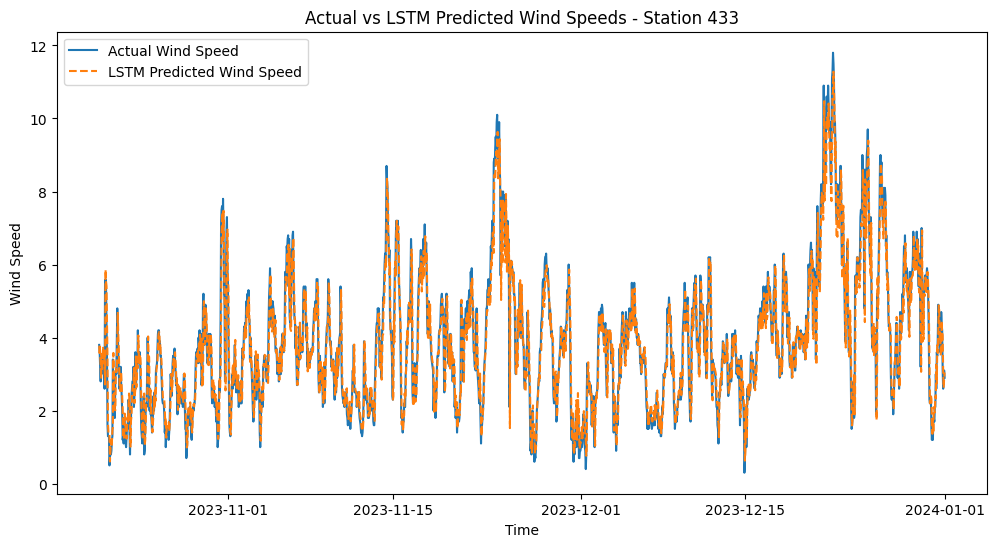

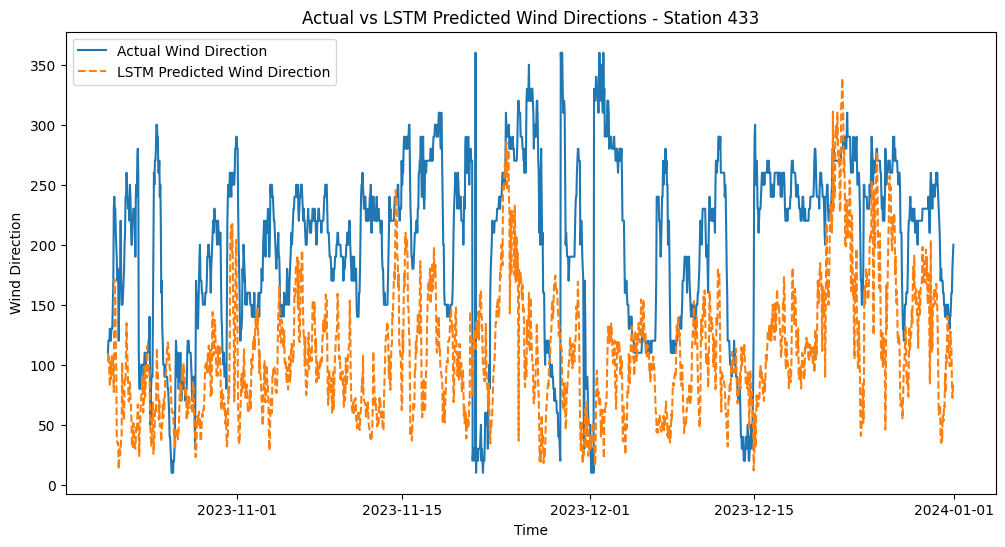

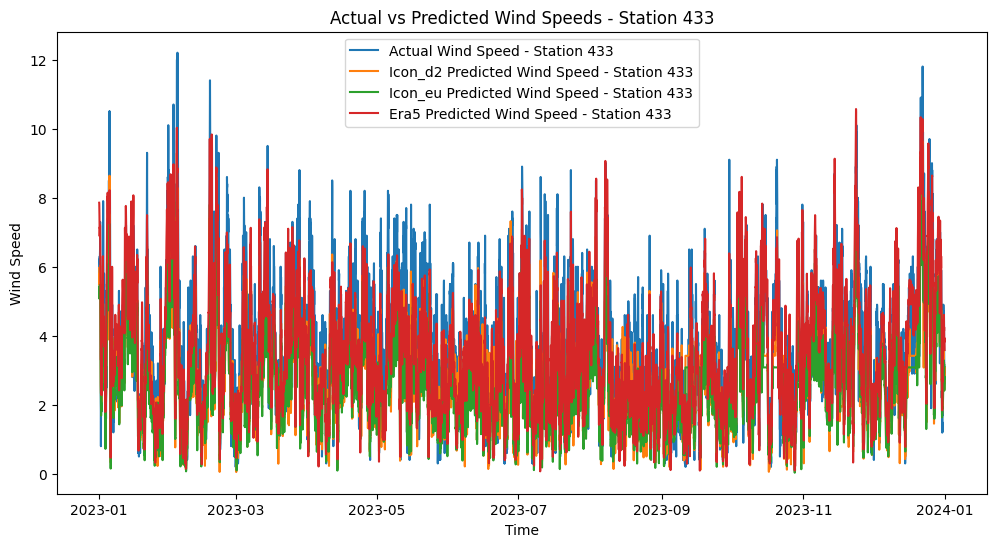

Processing Station ID: 701
Epoch 1/25
175/175 [==============================] - 6s 24ms/step - loss: 0.0135 - val_loss: 0.0064
Epoch 2/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 4/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/25
175/175 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 10/25
175/175 [==============================] - 2s 14ms/s

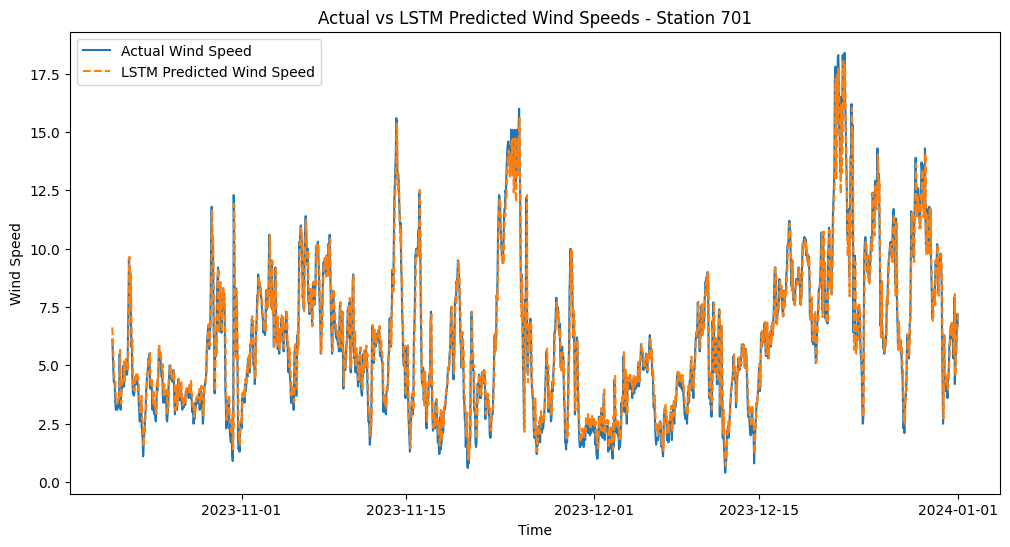

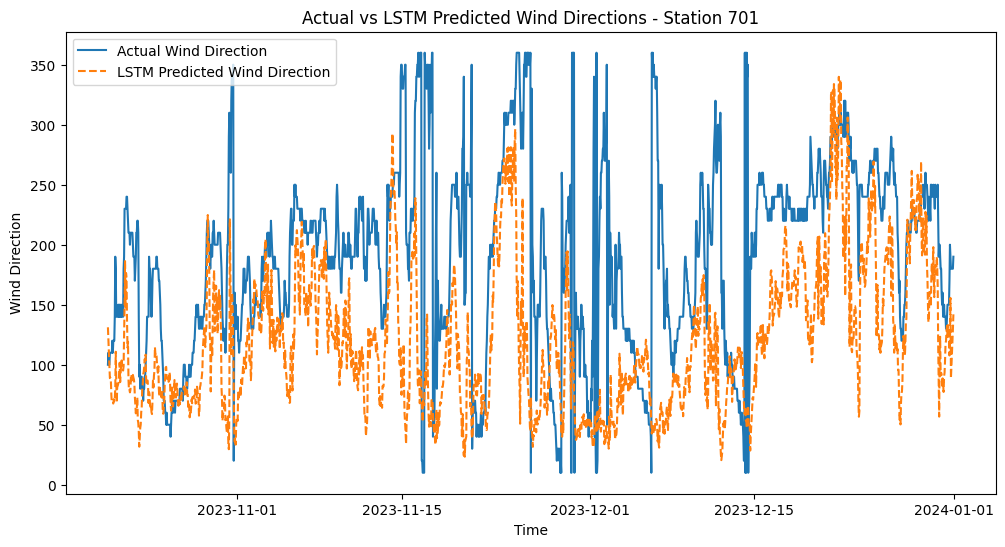

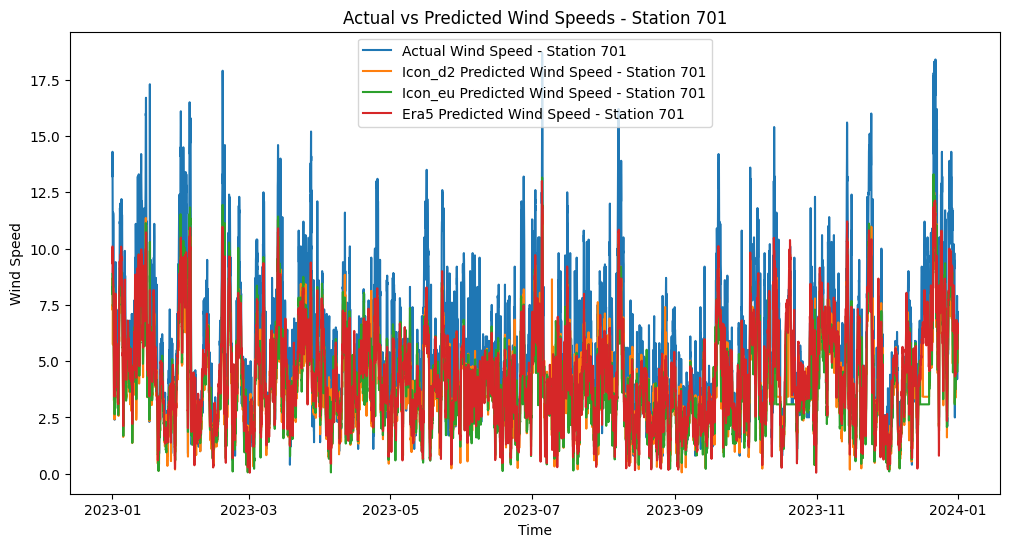

Processing Station ID: 1200
Epoch 1/25
175/175 [==============================] - 6s 23ms/step - loss: 0.0182 - val_loss: 0.0068
Epoch 2/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 3/25
175/175 [==============================] - 3s 16ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/25
175/175 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/25
175/175 [==============================] - 3s 16ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/25
175/175 [==============================] - 3s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/25
175/175 [==============================] - 3s 16ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/25
175/175 [==============================] - 3s 17ms/

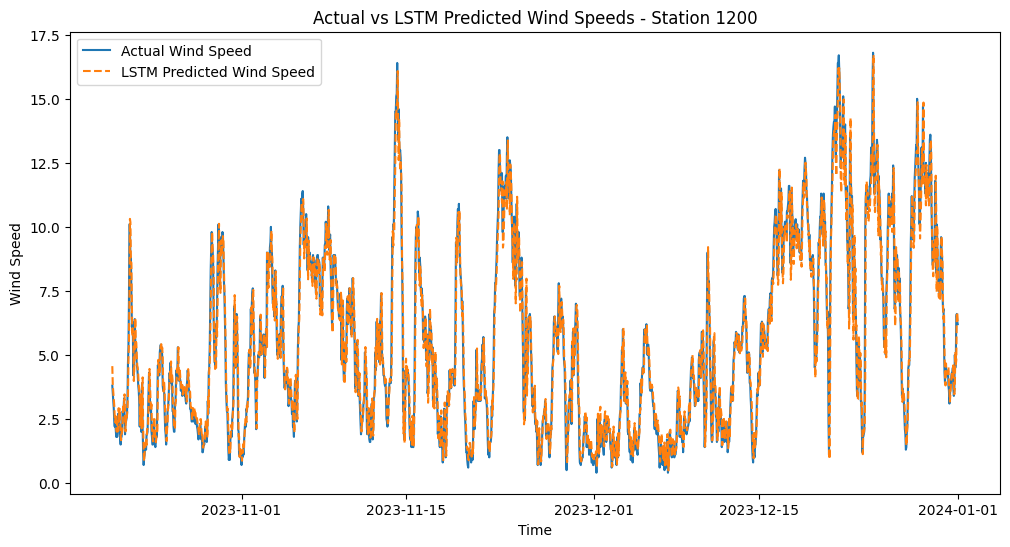

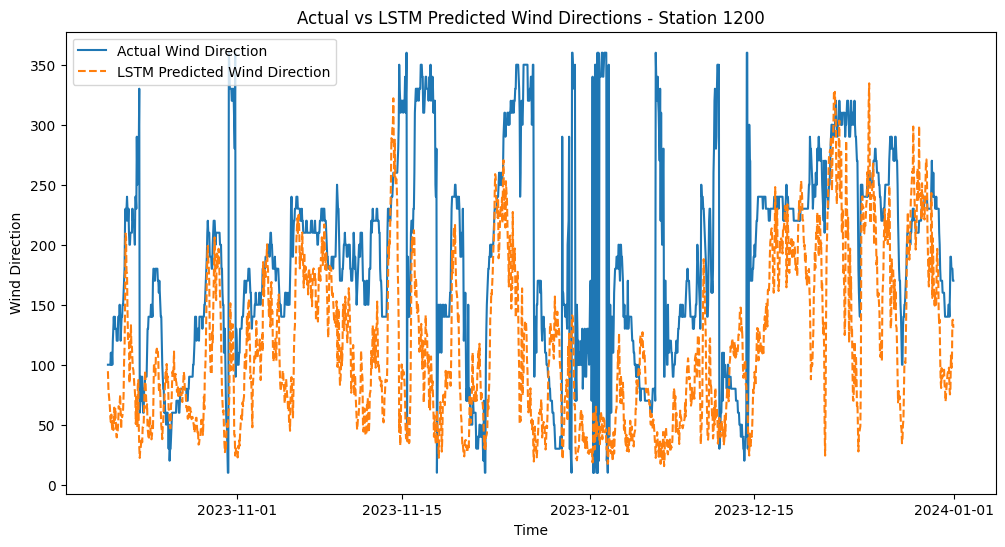

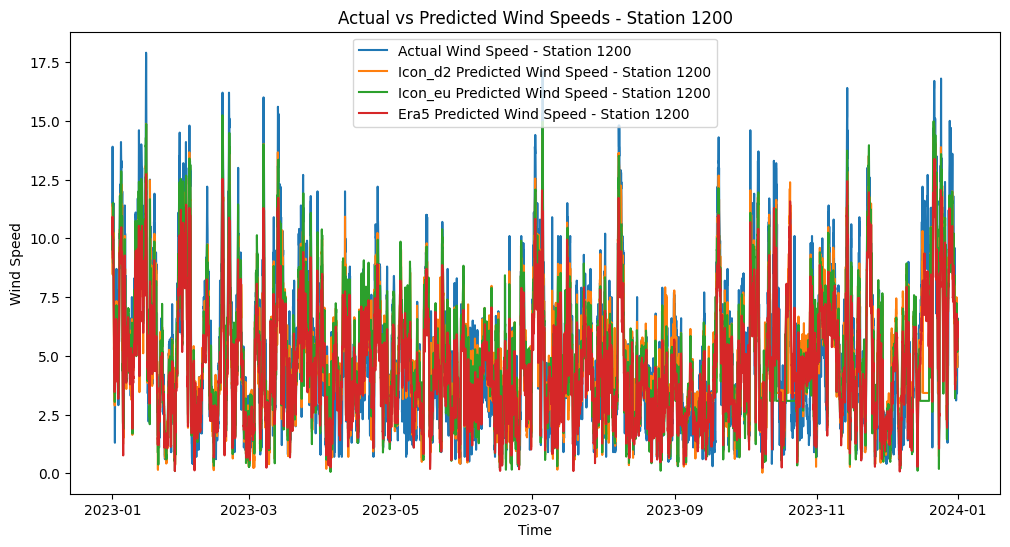

Processing Station ID: 2023
Epoch 1/25
175/175 [==============================] - 5s 20ms/step - loss: 0.0199 - val_loss: 0.0072
Epoch 2/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 3/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 4/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 5/25
175/175 [==============================] - 3s 17ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 6/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 7/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 8/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 9/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 10/25
175/175 [==============================] - 3s 18ms/

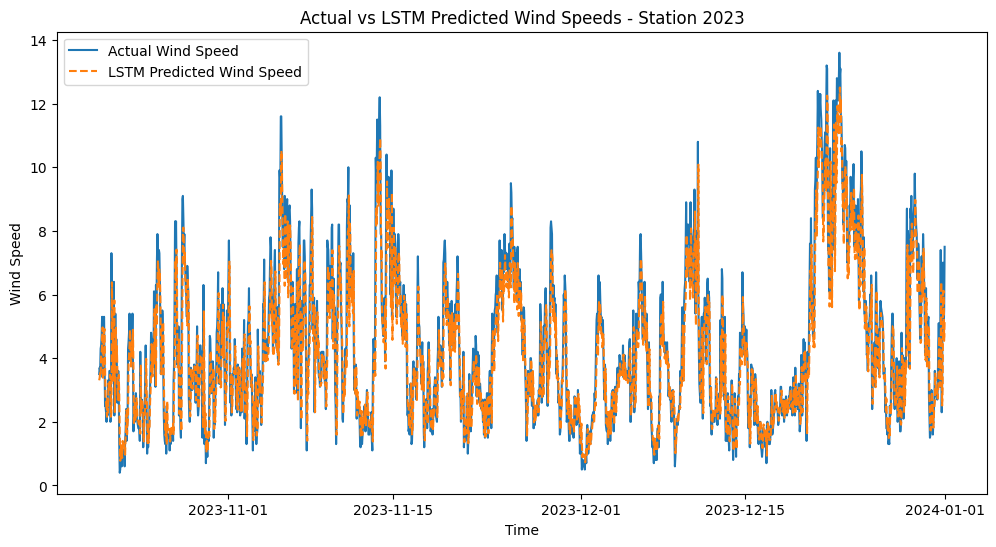

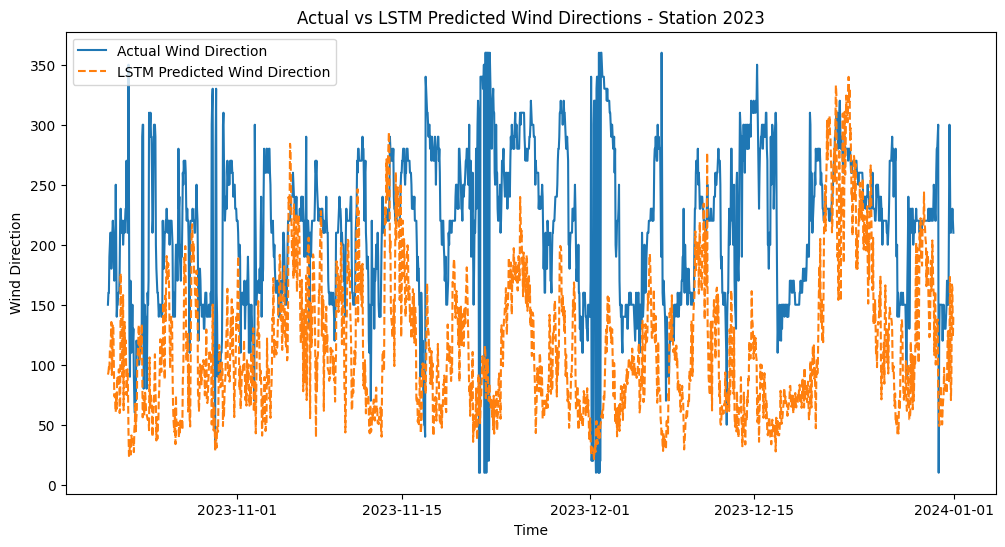

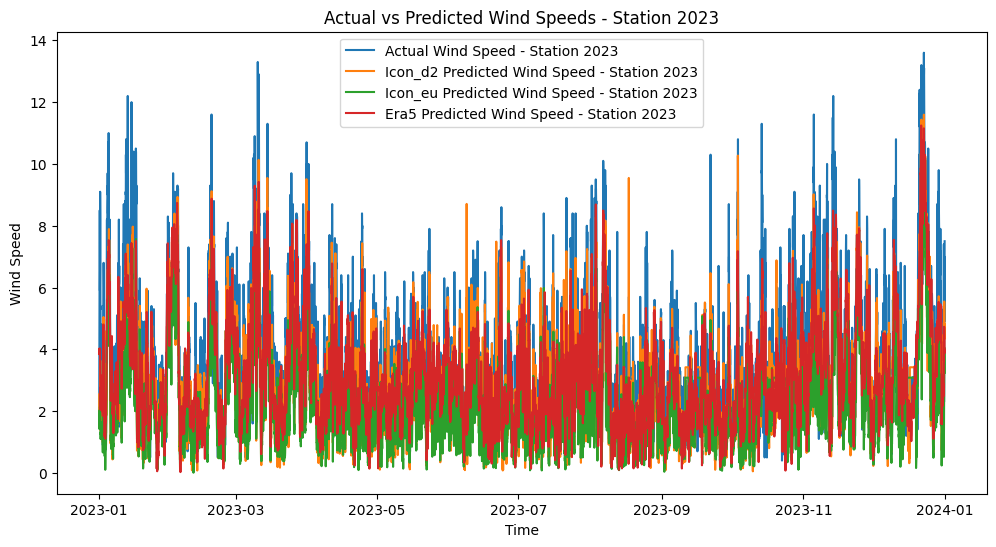

Processing Station ID: 3402
Epoch 1/25
175/175 [==============================] - 6s 24ms/step - loss: 0.0140 - val_loss: 0.0085
Epoch 2/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 3/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 4/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 5/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 6/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/25
175/175 [==============================] - 5s 26ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/25
175/175 [==============================] - 5s 27ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 9/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 10/25
175/175 [==============================] - 3s 19ms/

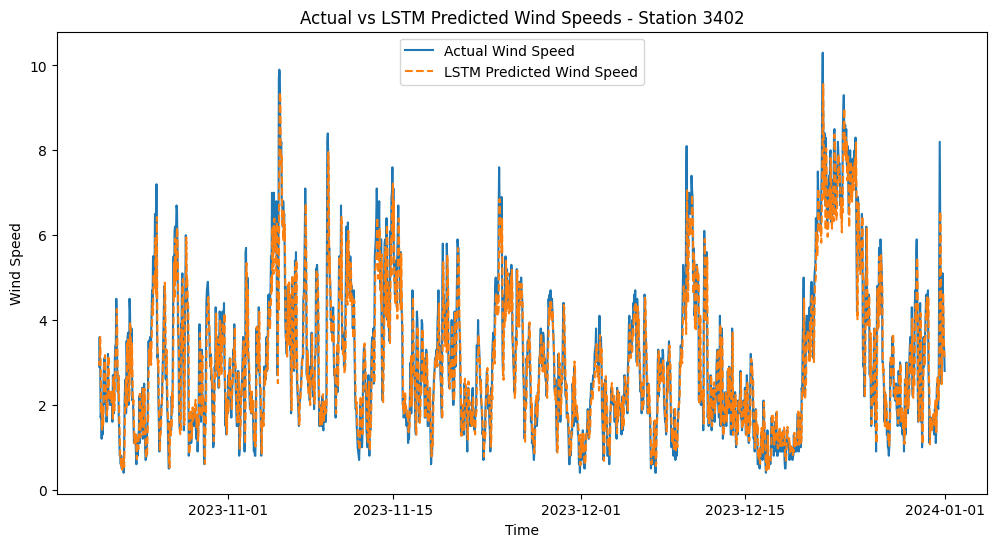

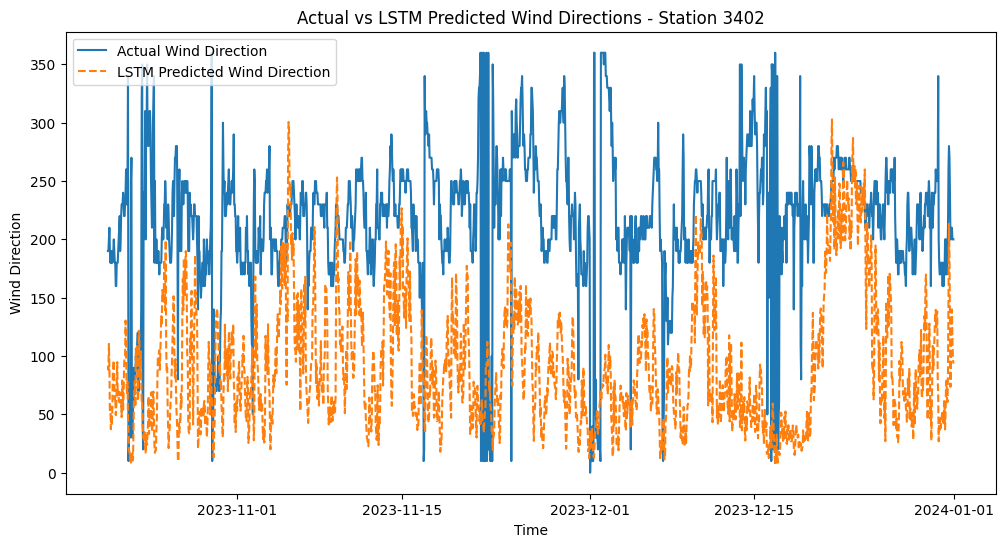

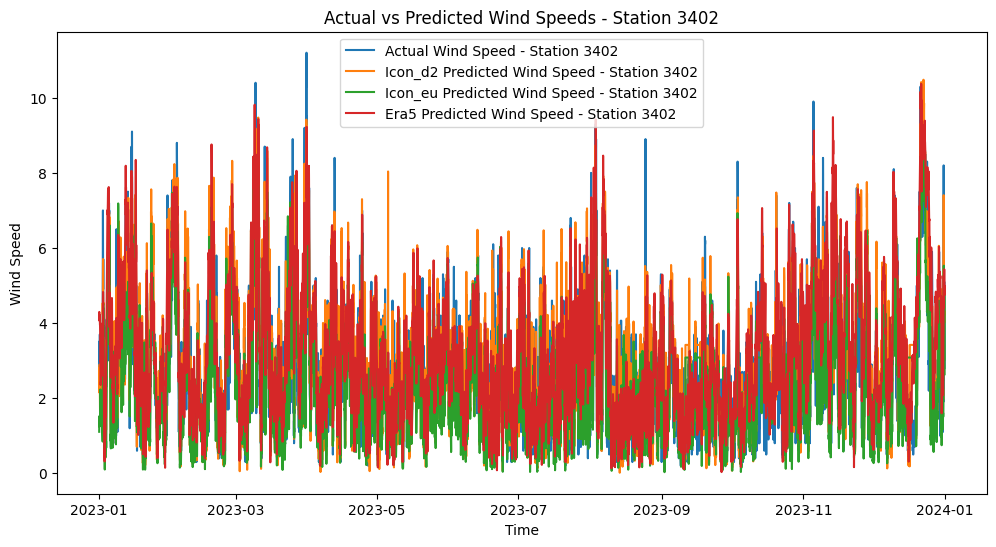

Processing Station ID: 3821
Epoch 1/25
175/175 [==============================] - 6s 22ms/step - loss: 0.0176 - val_loss: 0.0059
Epoch 2/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 3/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 4/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 5/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 6/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 7/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 8/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 10/25
175/175 [==============================] - 4s 21ms/

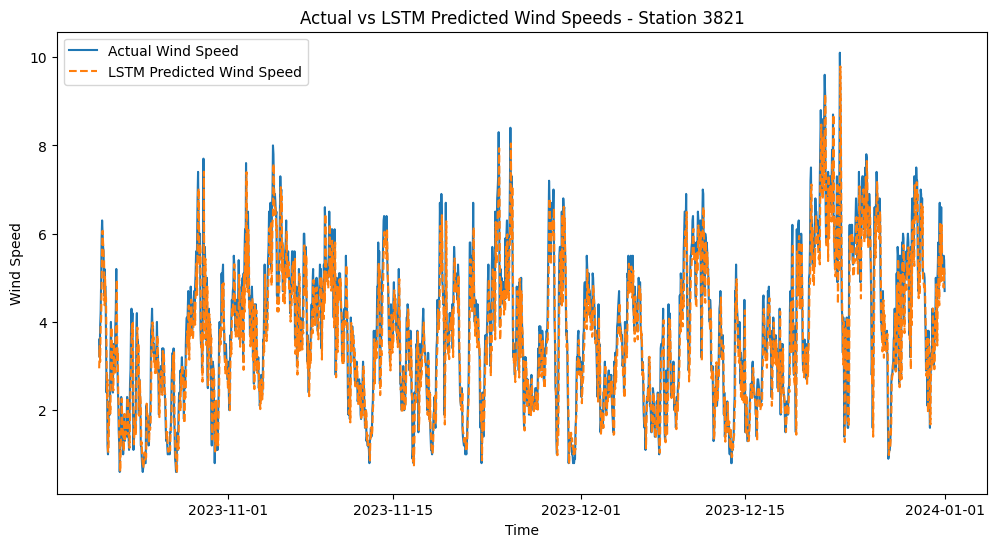

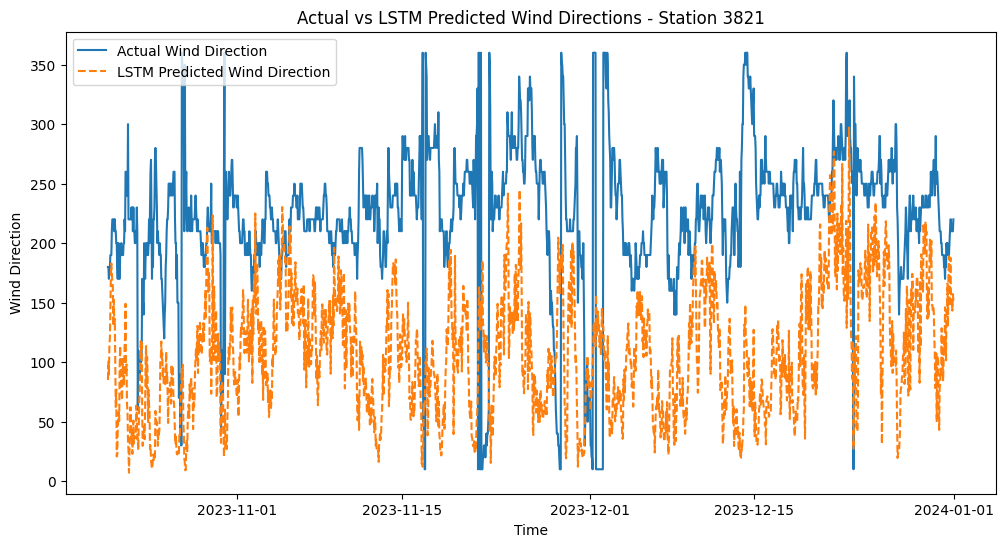

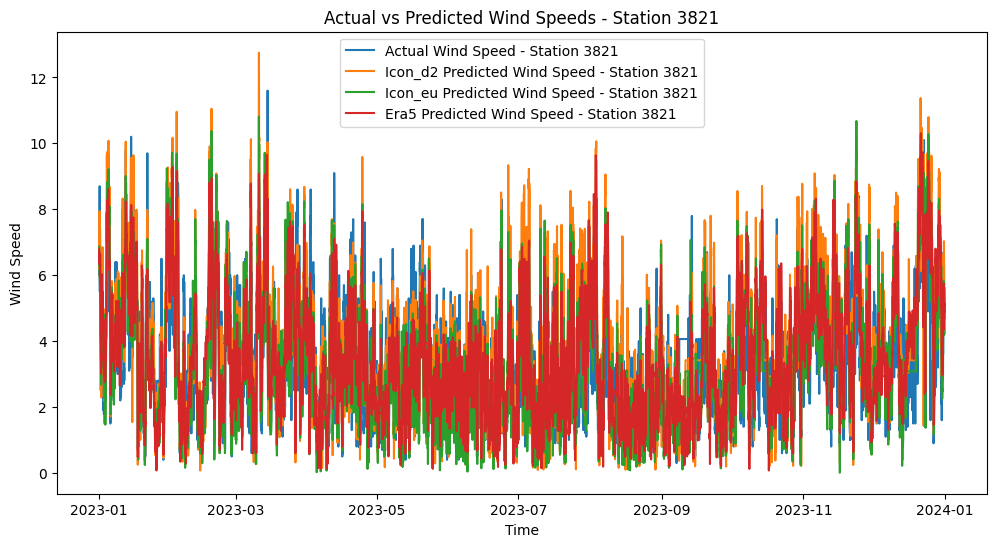

Processing Station ID: 4625
Epoch 1/25
175/175 [==============================] - 6s 21ms/step - loss: 0.0189 - val_loss: 0.0052
Epoch 2/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 3/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 4/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 5/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/25
175/175 [==============================] - 3s 20ms/

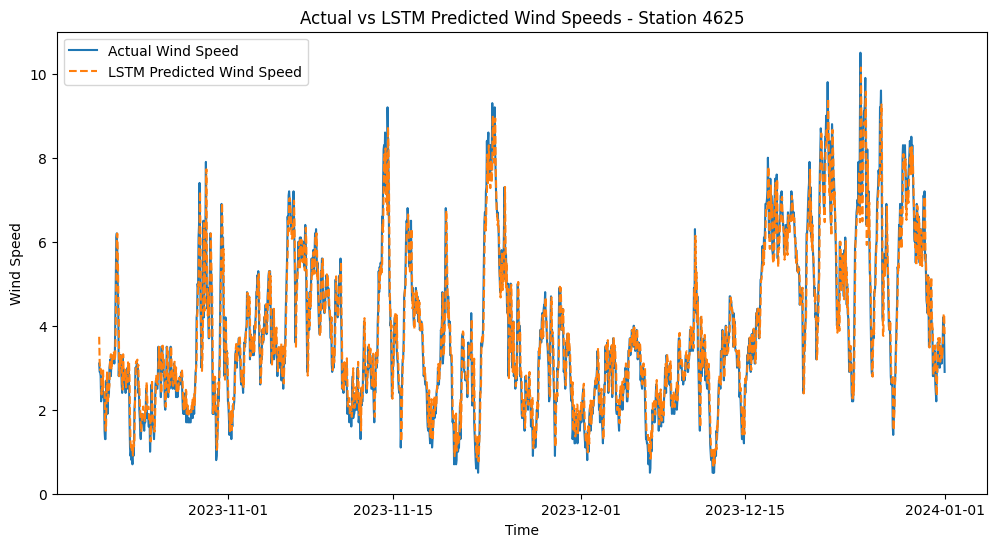

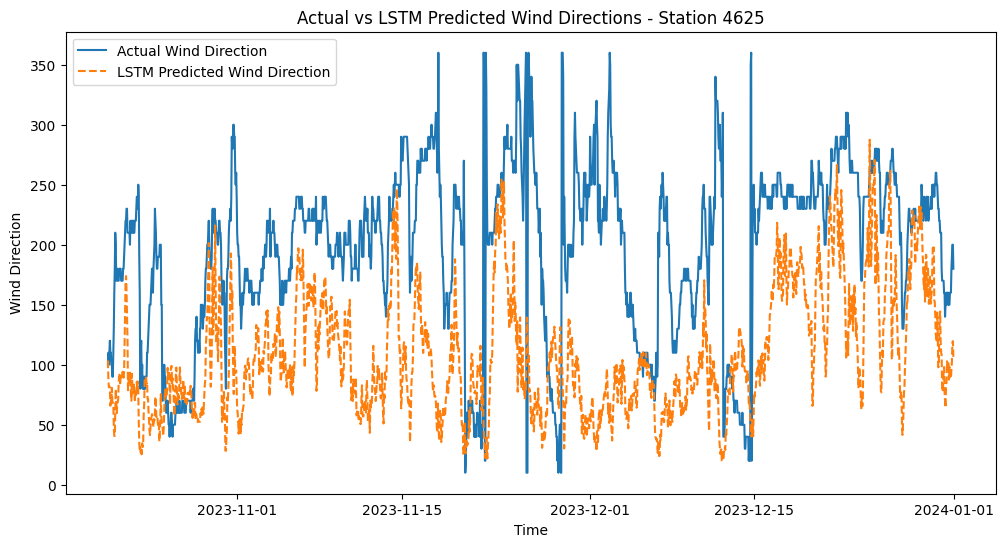

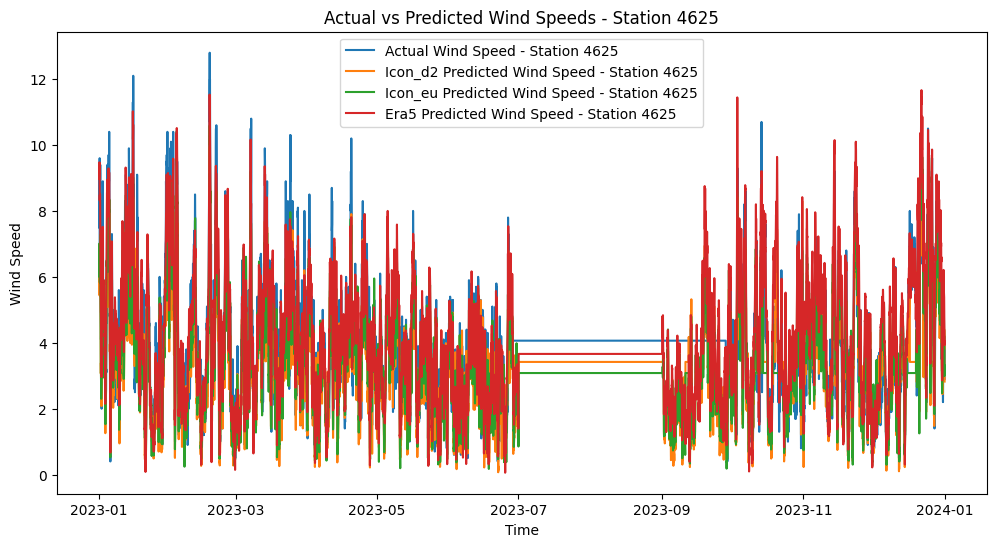

Processing Station ID: 5426
Epoch 1/25
175/175 [==============================] - 6s 21ms/step - loss: 0.0150 - val_loss: 0.0053
Epoch 2/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 3/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 4/25
175/175 [==============================] - 4s 23ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 5/25
175/175 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/25
175/175 [==============================] - 3s 18ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/25
175/175 [==============================] - 4s 23ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/25
175/175 [==============================] - 4s 20ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 10/25
175/175 [==============================] - 3s 18ms/

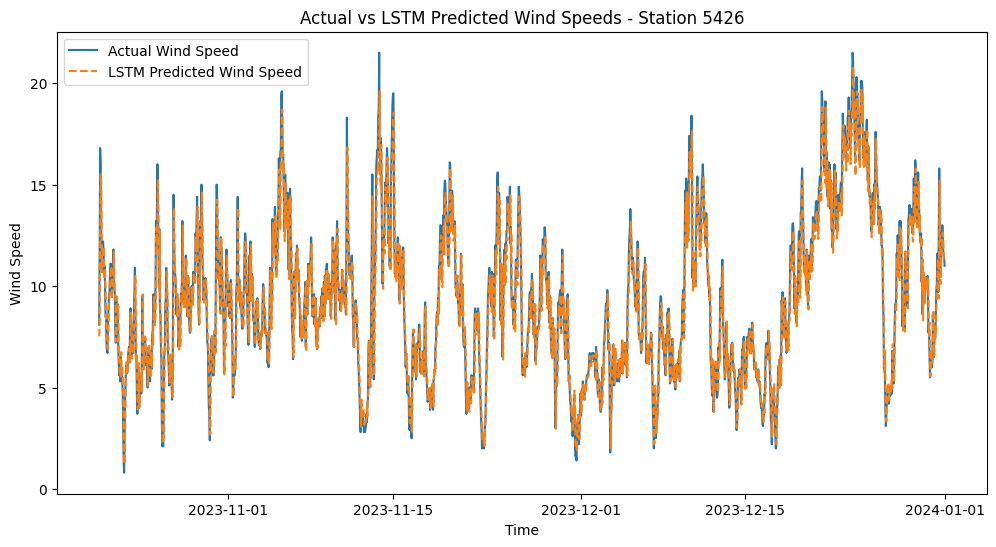

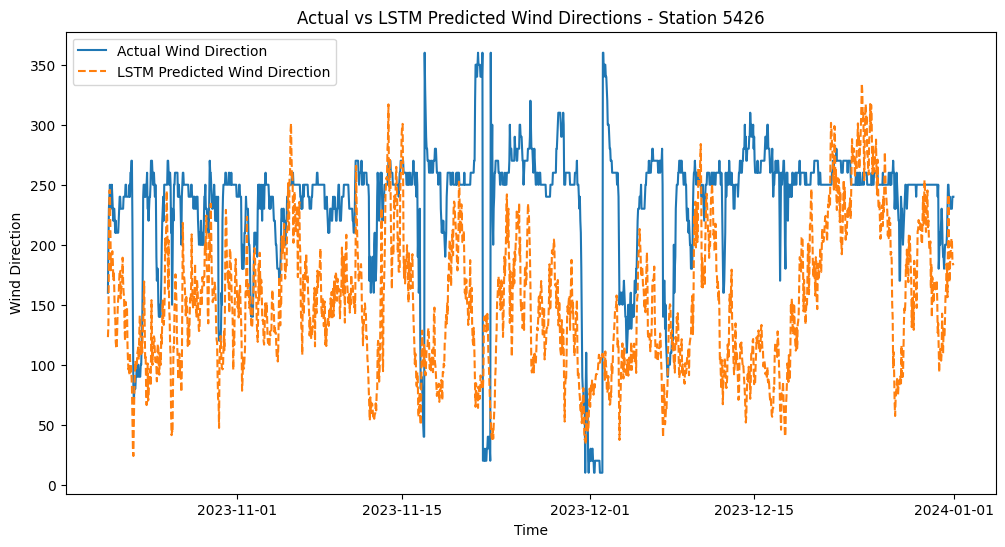

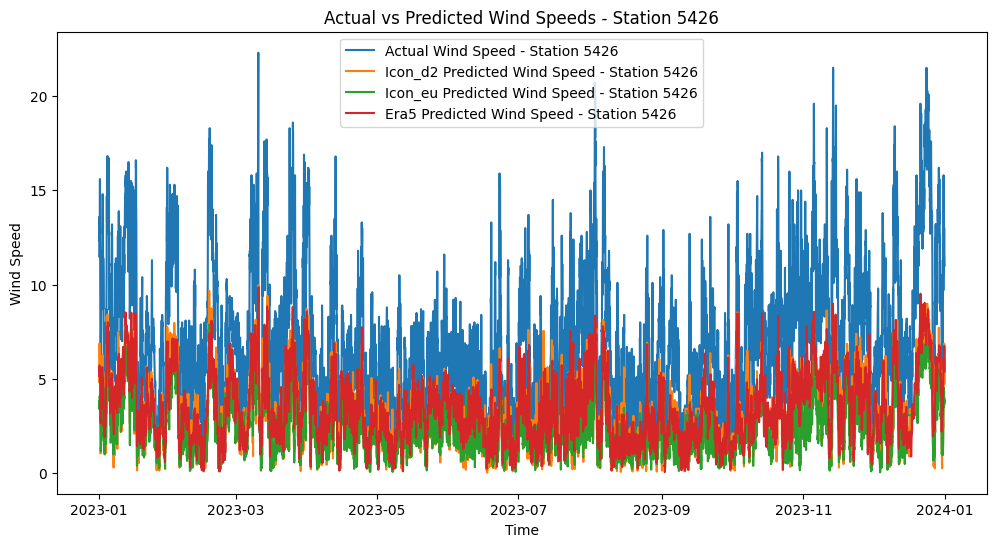

Processing Station ID: 15207
Epoch 1/25
175/175 [==============================] - 7s 27ms/step - loss: 0.0192 - val_loss: 0.0066
Epoch 2/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0092 - val_loss: 0.0060
Epoch 3/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 4/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 5/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 6/25
175/175 [==============================] - 3s 20ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 8/25
175/175 [==============================] - 3s 19ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/25
175/175 [==============================] - 4s 21ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 10/25
175/175 [==============================] - 4s 21ms

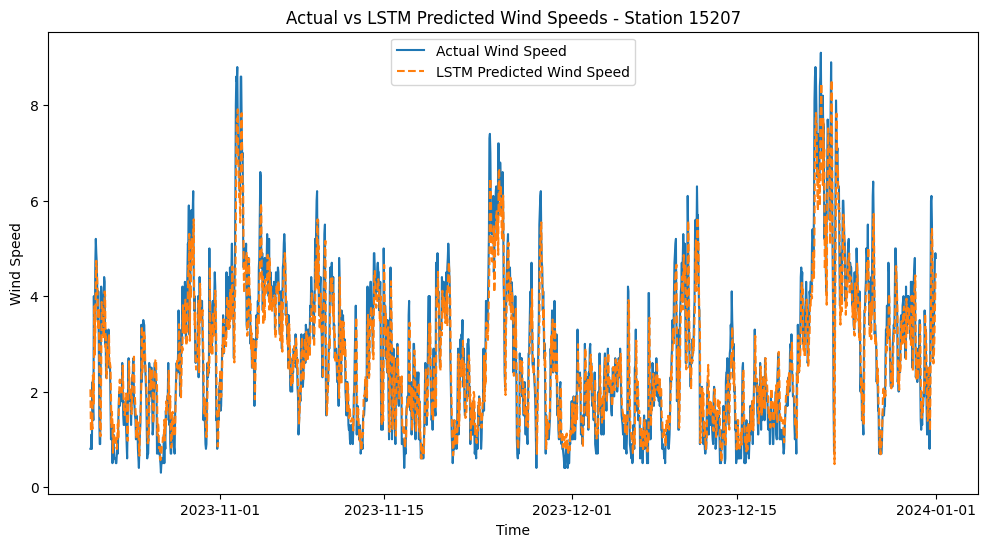

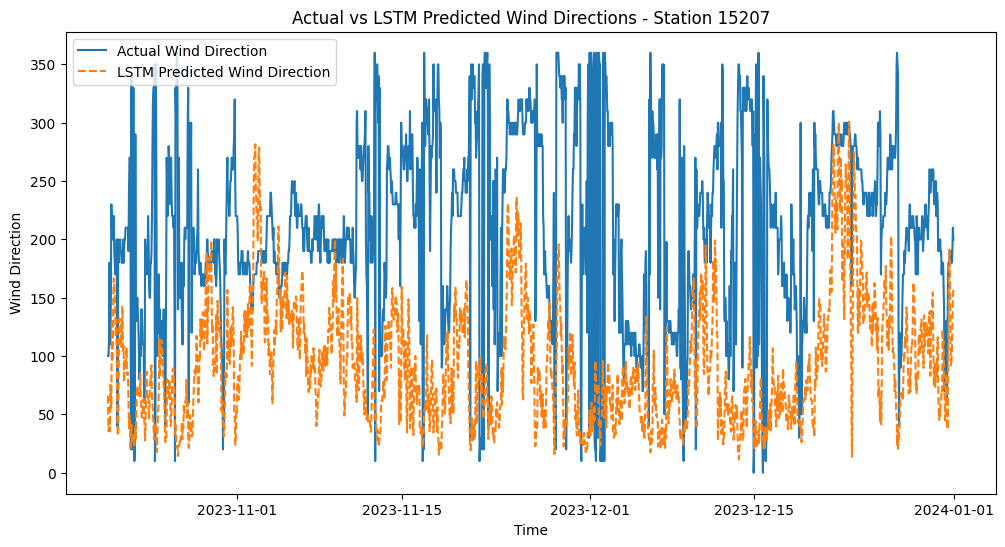

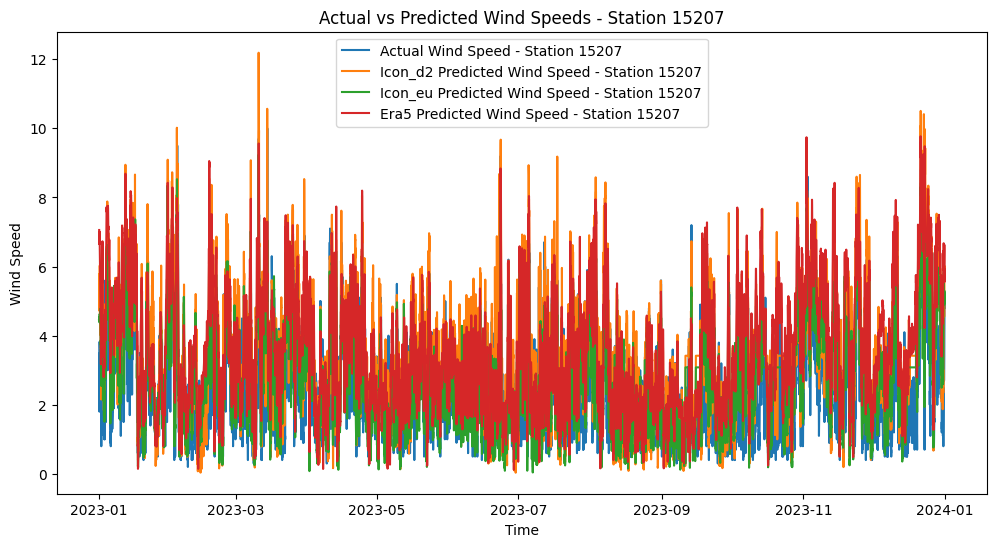

In [ ]:

# Initialize lists to store predictions for plotting
y_pred_icon_d2 = []
y_pred_icon_eu = []
y_pred_era5 = []

# Iterate over each station
station_ids = np.unique(wind_data['station_id'].values)

# Helper function to create LSTM data
def create_lstm_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# LSTM parameters
time_steps = 24  # Number of time steps to look back
n_features = 2  # Number of features (speed and direction)

for i, station_id in enumerate(station_ids):
    print(f"Processing Station ID: {station_id}")

    # Filter data for the current station
    station_data = wind_data.sel(station_id=station_id)
    wind_speed = station_data['measured_wind_speed'].values
    wind_direction = station_data['measured_wind_direction'].values
    time = pd.to_datetime(station_data['time'].values)

    # Split data into training and testing sets (80% training, 20% testing)
    split_idx = int(len(wind_speed) * 0.8)
    train_speed, test_speed = wind_speed[:split_idx], wind_speed[split_idx:]
    train_direction, test_direction = wind_direction[:split_idx], wind_direction[split_idx:]

    # Scale the data
    scaler_speed = MinMaxScaler(feature_range=(0, 1))
    scaler_direction = MinMaxScaler(feature_range=(0, 1))

    train_speed_scaled = scaler_speed.fit_transform(train_speed.reshape(-1, 1))
    test_speed_scaled = scaler_speed.transform(test_speed.reshape(-1, 1))
    train_direction_scaled = scaler_direction.fit_transform(train_direction.reshape(-1, 1))
    test_direction_scaled = scaler_direction.transform(test_direction.reshape(-1, 1))

    # Combine speed and direction into one dataset
    train_combined = np.hstack((train_speed_scaled, train_direction_scaled))
    test_combined = np.hstack((test_speed_scaled, test_direction_scaled))

    # Create LSTM data
    X_train, y_train = create_lstm_data(train_combined, time_steps)
    X_test, y_test = create_lstm_data(test_combined, time_steps)

    # Split targets into speed and direction
    y_train_speed = y_train[:, 0]
    y_train_direction = y_train[:, 1]
    y_test_speed = y_test[:, 0]
    y_test_direction = y_test[:, 1]

    # Reshape data to fit LSTM input shape (samples, time_steps, features)
    X_train = X_train.reshape((X_train.shape[0], time_steps, n_features))
    X_test = X_test.reshape((X_test.shape[0], time_steps, n_features))

    # Build the LSTM model
    def build_lstm_model():
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(time_steps, n_features)))
        model.add(Dense(n_features))  # Output two values: speed and direction
        model.compile(optimizer='adam', loss='mse')
        return model

    # Train the LSTM model
    model = build_lstm_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, [y_train_speed, y_train_direction],
              validation_split=0.2, epochs=25, batch_size=32, verbose=1,
              callbacks=[early_stopping])

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_speed = y_pred[:, 0]
    y_pred_direction = y_pred[:, 1]

    # Inverse transform the predictions
    y_pred_speed = scaler_speed.inverse_transform(y_pred_speed.reshape(-1, 1))
    y_test_speed = scaler_speed.inverse_transform(y_test_speed.reshape(-1, 1))
    y_pred_direction = scaler_direction.inverse_transform(y_pred_direction.reshape(-1, 1))
    y_test_direction = scaler_direction.inverse_transform(y_test_direction.reshape(-1, 1))

    # Plot actual vs predicted wind speeds
    plt.figure(figsize=(12, 6))
    plt.plot(time[split_idx + time_steps:], y_test_speed, label='Actual Wind Speed')
    plt.plot(time[split_idx + time_steps:], y_pred_speed, label='LSTM Predicted Wind Speed', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.title(f'Actual vs LSTM Predicted Wind Speeds - Station {station_id}')
    plt.show()

    # Plot actual vs predicted wind directions
    plt.figure(figsize=(12, 6))
    plt.plot(time[split_idx + time_steps:], y_test_direction, label='Actual Wind Direction')
    plt.plot(time[split_idx + time_steps:], y_pred_direction, label='LSTM Predicted Wind Direction', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Wind Direction')
    plt.legend()
    plt.title(f'Actual vs LSTM Predicted Wind Directions - Station {station_id}')
    plt.show()

    # Store predicted values for plotting
    y_pred_icon_d2.append(station_data['icon_d2_wind_speed'].values)
    y_pred_icon_eu.append(station_data['icon_eu_wind_speed'].values)
    y_pred_era5.append(station_data['era5_wind_speed'].values)

    # Plot actual vs predicted wind speeds using ICON and ERA5
    plt.figure(figsize=(12, 6))
    plt.plot(time, wind_speed, label=f'Actual Wind Speed - Station {station_id}')
    plt.plot(time, y_pred_icon_d2[i], label=f'Icon_d2 Predicted Wind Speed - Station {station_id}')
    plt.plot(time, y_pred_icon_eu[i], label=f'Icon_eu Predicted Wind Speed - Station {station_id}')
    plt.plot(time, y_pred_era5[i], label=f'Era5 Predicted Wind Speed - Station {station_id}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.title(f'Actual vs Predicted Wind Speeds - Station {station_id}')
    plt.show()
